In [1]:
import matplotlib.pyplot as plt  # Data 可視化
import seaborn as sns  # Data可視化
import pandas as pd  # TableData加工
import numpy as np  # 数値計算の効率化
import random  # 乱数の取り扱い
from sklearn.preprocessing import LabelEncoder  # Category変数の生成
import lightgbm as lgb  # 機械学習Model
from sklearn.model_selection import KFold  # Cross-validation の取り扱い
from sklearn.metrics import mean_squared_error  # 平均二乗誤差の取り扱い
import warnings

plt.style.use("ggplot")  # 描画の Design型
np.random.seed(1234)  # 乱数の種を指定
random.seed(1234)  # 乱数の種を指定
warnings.filterwarnings("ignore")  # 注意書きを非表示に

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

# Benchmark を作成する
実行する各処理が精度向上にどれだけ効果があるかを検証するために、「何も考えずに最低限Category変数を LabelEncode しただけの Data を LightGBM に入れ時の精度」 を確認しておく。

## LightGBM で予測する
最初に、LightGBM を使用する。
LightGBM は各変数の重要度を出すことができる為、今後の処理の優先順位などを考える指標になる。

In [5]:
# 各変数の型の確認
df_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [6]:
# MSZoning の各分類ごとの個数を確認する
df_train["MSZoning"].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

LightGBM に読み込めるのは int型, float型となるため、文字列の Data を Category変数に変換していく

### 学習Data と Test-data を連結して前処理を行なう
もし学習Data で変換表を作成した場合、Test-data にしか存在しないものがあると、変換できずに Error になってしまうので、学習Data と Test-data を結合し、一括で LabelEncoding で Category変数に変換する。

In [7]:
# 学習Data と Test-data の連結
df_all = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)
df_all

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


SalePrice の Data が存在するものが学習Data, 存在しないものが Test-data になる為、予測の際は SalePrice のData の有無で Data を分割する。

In [8]:
# 目的変数である SalePrice の値を取得
df_all["SalePrice"]

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
2914         NaN
2915         NaN
2916         NaN
2917         NaN
2918         NaN
Name: SalePrice, Length: 2919, dtype: float64

### Category変数を数値に変換する

In [9]:
# Object型の 変数を取得
categories = df_all.columns[df_all.dtypes == "object"]
categories

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

### 欠損値を数値に変換する
欠損値について NaN 自体に意味がある変数がある為、missing という文字列に変換後、数値に変換する。
また、Category変数であることを明示するため、astype("category")としておく。

In [10]:
# 欠損値を数値に変換する
for category in categories:
    label_encoder = LabelEncoder()
    print(category)

    df_all[category].fillna("missing", inplace=True)
    label_encoder = label_encoder.fit(df_all[category])
    df_all[category] = label_encoder.transform(df_all[category])
    df_all[category] = df_all[category].astype("category")

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [11]:
df_all

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500.0
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000.0
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,4,21.0,1936,1,2,3,3,0,...,0,3,4,4,0,6,2006,8,4,NaN
2915,2916,160,4,21.0,1894,1,2,3,3,0,...,0,3,4,4,0,4,2006,8,0,NaN
2916,2917,20,3,160.0,20000,1,2,3,3,0,...,0,3,4,4,0,9,2006,8,0,NaN
2917,2918,85,3,62.0,10441,1,2,3,3,0,...,0,3,2,2,700,7,2006,8,4,NaN


### 再び学習Data と Test-data に戻す
以上の処理で、LightGBM など各種機械学習Model に Data を読み込み込めるようになった為、再び学習Data と Test-data に戻す。

In [12]:
# Data を df_train と df_test に戻す
df_train_le = df_all.loc[~df_all["SalePrice"].isnull()]
df_test_le = df_all.loc[df_all["SalePrice"].isnull()]

## Cross-validation を用いて Model の学習・予測を行なう
学習Data を３分割して、各Data で Model を作成した際の Test-data に対する予測精度の平均を確認してみる。

In [13]:
folds = 3
kf = KFold(n_splits=folds)

Hyper-parameter について、ひとまず回帰分析用の Model である "objective":"regression" のみを設定する

In [14]:
# LightGBM の Hyper-parameter を設定
lgbm_params = {
    "objective": "regression",
    "random_seed": 1234
}

- 目的変数: SalePrice
- 説明変数: 学習Data の全変数から目的変数である「SalePrice」と学習に不要な「ID」を除いたもの

を指定する

In [15]:
# 説明変数、目的変数を指定
train_X = df_train_le.drop(["SalePrice", "Id"], axis=1)
train_Y = df_train_le["SalePrice"]

### 各foldごとに作成した Model ごとの予測値を保存する

In [16]:
models = []  # 各fold ごとに作成した Model を格納
rmses = []  # rmse の計算結果を格納
out_of_fold = np.zeros(len(train_X))  # その Data以外を用いて作成した Model でその Data の目的変数を予測した値

for train_index, val_index in kf.split(train_X):  # 各kf.split()で、train_X を分割した結果の index を得る
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10, )

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse, "\n")

    models.append(model_lgb)
    rmses.append(tmp_rmse)
    out_of_fold[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2964
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 179726.031860
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 1.57807e+09
[20]	valid_0's l2: 7.38516e+08
[30]	valid_0's l2: 5.93255e+08
[40]	valid_0's l2: 5.6061e+08
[50]	valid_0's l2: 5.48225e+08
[60]	valid_0's l2: 5.46182e+08
[70]	valid_0's l2: 5.51735e+08
Early stopping, best iteration is:
[55]	valid_0's l2: 5.45194e+08
0.12719558859476132 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2985
[LightGBM] [Info] Number

平均 RMSE を計算する

In [17]:
sum(rmses) / len(rmses)

0.13591644792333177

上記の値から予測精度を改善していく。

### 現状の予測値と実際の値の違いを確認する
- 現状の予測値: `out_of_fold`
- 実際の値: `train_Y`

となるので、現状の予測値と実際の値の違いを見ておく。

In [18]:
# 現状の予測値と実際の値の違いを可視化
df_actual_pred = pd.DataFrame({
    "actual": train_Y,
    "pred": out_of_fold
})

<Axes: >

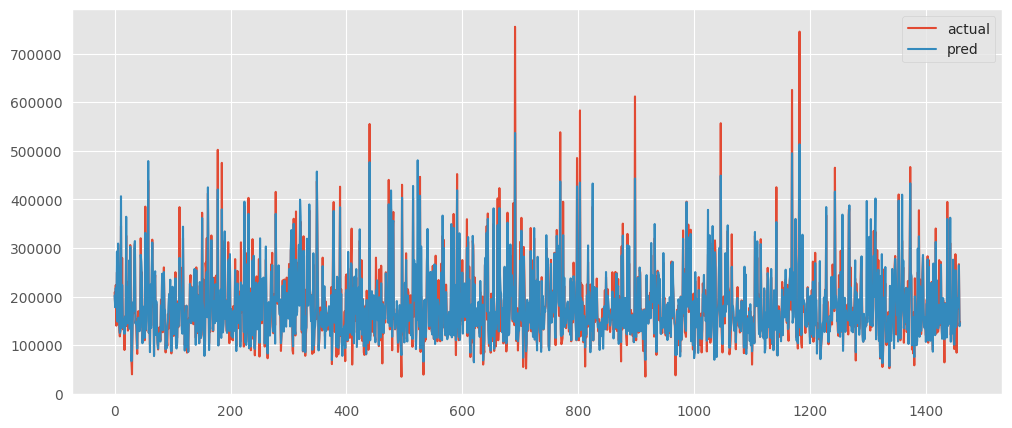

In [19]:
df_actual_pred.plot(figsize=(12, 5))
# Id ごとの横比較をしたいわけではないので線Graph を利用するのは違和感を感じるかもしれないが Simple な Code で各Id ごとの予測値と実際の値の差を確認。

大きな傾向としては追えているが、実際の値が大きくなる時に十分に大きな値として予測できていない様子。
- このような値をうまく捉えるためにどのような工夫をすべきか。
- 通常の傾向とは異なる「外れ値」として学習から除外するか。

などを検討していく。

### 各変数の重要度を確認する
そのままでは変数の数が多いので、変数の数を制限して表示する。

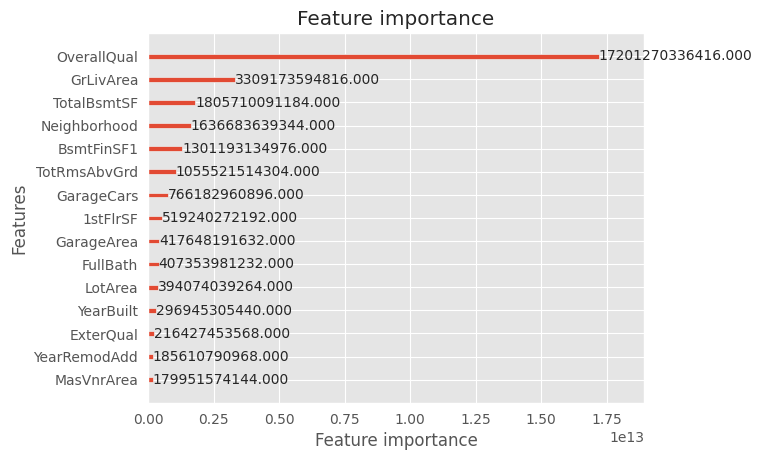

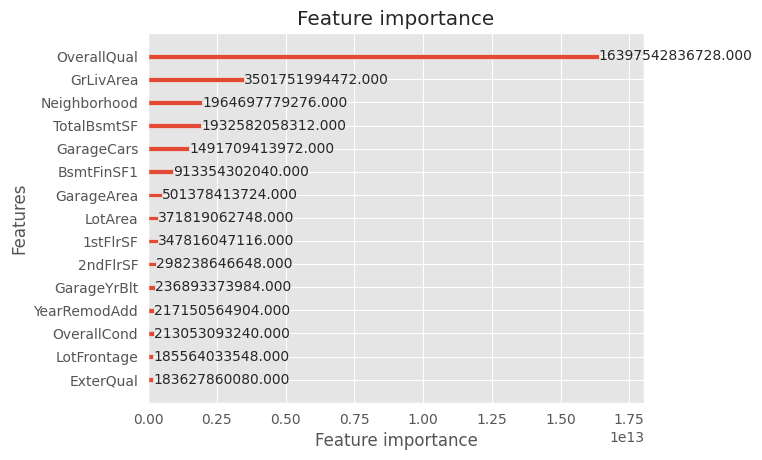

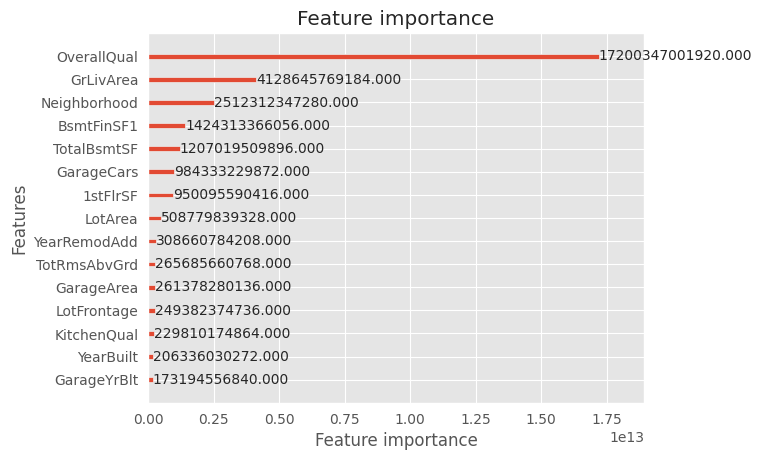

In [20]:
# 変数の数を制限して各変数の重要度を表示
for model in models:
    lgb.plot_importance(model, importance_type="gain", max_num_features=15)

#### OverallQual（全体の質感などを含めた Quality）:
数値が入っているが、10 が Very Excellent, 1 が Very poor となっている Category変数。Category変数として明示することで、より内部的に適切に処理してくれ、必要に応じて前処理を行なう必要。

#### GrLivArea（住居部分の廣さ）:
外れ値などが含まれていないか確認が必要。

#### その他:
- TotalBsmtSF（地下の廣さ）
- GarageCars（Garage に入る車の数）
- GarageArea（Garage の広さ）
- GarageYrBlt（Garage の年数）

などが続く。重要度の高いものは優先的に確認していく。

# 目的変数の前処理: 目的変数の分布を確認する

In [21]:
df_train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: ylabel='Frequency'>

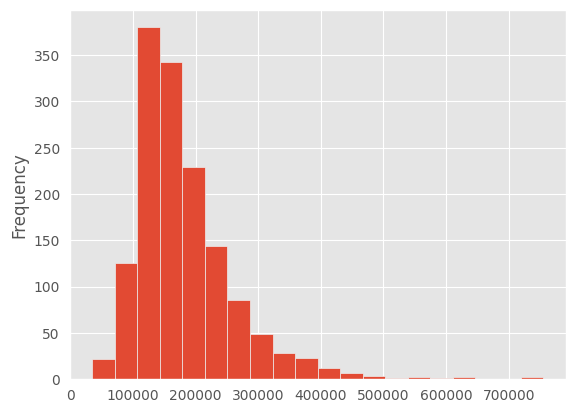

In [22]:
df_train["SalePrice"].plot.hist(bins=20)

左側に最頻値が寄っている Poison分布に近い分布となっている。

### 目的変数を数値化する
- 一般的に機械学習や統計的な処理の多くは Data が正規分布であることを想定している。
- 感覚的には、平均値・中央値付近に多くの Data が存在していることから、そこの差異が重要で詳細を確認把握できるようにしていきたい。
- Competition の評価指標が RMSE と実際の値の対数と予測値の対数になる。

以上から、目的変数を対数化してみる

In [23]:
np.log(df_train["SalePrice"])

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

<Axes: ylabel='Frequency'>

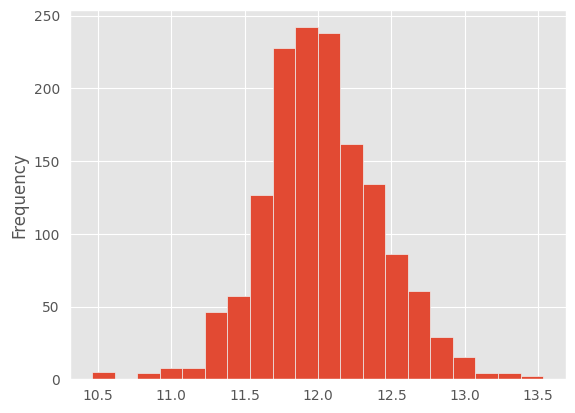

In [24]:
np.log(df_train["SalePrice"]).plot.hist(bins=20)

最頻値を中心として左右対称に近い分布となった。
以降は、この対数をとった目的変数を用いて Model を作成していく。

### 目的変数をの対数化による予測精度の向上を確認する

In [25]:
df_train_le["SalePrice_log"] = np.log(df_train_le["SalePrice"])

In [26]:
train_X = df_train_le.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)
train_Y = df_train_le["SalePrice_log"]

In [27]:
models = []
rmses_1 = []
out_of_fold = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10, )

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models.append(model_lgb)
    rmses_1.append(tmp_rmse)
    out_of_fold[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2964
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 12.017607
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0436707
[20]	valid_0's l2: 0.0219638
[30]	valid_0's l2: 0.0178863
[40]	valid_0's l2: 0.0168272
[50]	valid_0's l2: 0.0165421
[60]	valid_0's l2: 0.0164067
[70]	valid_0's l2: 0.0163235
[80]	valid_0's l2: 0.0162611
[90]	valid_0's l2: 0.0162673
[100]	valid_0's l2: 0.0163207
Did not meet early stopping. Best iteration is:
[81]	valid_0's l2: 0.0162538
0.12749050377720011
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2985
[LightGB

In [28]:
print(f"目的変数を事前に対数化しない: {sum(rmses) / len(rmses)}")
print(f"目的変数を事前に対数化する: {sum(rmses_1) / len(rmses_1)}")

目的変数を事前に対数化しない: 0.13591644792333177
目的変数を事前に対数化する: 0.13274830975285581


事前に対数化することで精度が向上した。

# 説明変数の前処理: 欠損値を確認する
本Data では欠損は入力Miss ではなく、意味があることに注意する。

In [29]:
# df_all の作成
df_all = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)

In [30]:
categories = df_all.columns[df_all.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [31]:
# 欠損値の数が上位40の変数を確認
df_all.isnull().sum().sort_values(ascending=False).head(40)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageFinish      159
GarageQual        159
GarageCond        159
GarageYrBlt       159
GarageType        157
BsmtExposure       82
BsmtCond           82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
Functional          2
BsmtHalfBath        2
BsmtFullBath        2
Utilities           2
BsmtFinSF1          1
BsmtFinSF2          1
SaleType            1
Electrical          1
GarageCars          1
TotalBsmtSF         1
GarageArea          1
Exterior2nd         1
Exterior1st         1
KitchenQual         1
BsmtUnfSF           1
Fireplaces          0
TotRmsAbvGrd        0
SaleCondition       0
OpenPorchSF         0
YrSold              0
dtype: int64

- SalePrice は df_test に含まれていないため欠損値があるのは当然。
- PoolQC, MiscFeature, Alley, Fence などは非常に多くの多くの欠損がある。
- 重要度の高い変数として出てきた Garage系の変数もいくつか欠損している。

### 欠損値の多い高級住宅設備に関する変数をまとめる
90%以上の Data が欠損している
- PoolQC
- MiscFeature
- Alley

といった高級住宅に関する設備項目は、値がないものがほとんどなので、まとめて高級な設備の有無に変換した上で、もとの Data は削除することにする。

In [32]:
# PoolQC の各分類ごとの個数
df_all["PoolQC"].value_counts()

Ex    4
Gd    4
Fa    2
Name: PoolQC, dtype: int64

値があるものは 10個しかない。

In [33]:
# 値があるものを1, 値がないものを 0 に変換
df_all.loc[~df_all["PoolQC"].isnull(), "PoolQC"] = 1
df_all.loc[df_all["PoolQC"].isnull(), "PoolQC"] = 0

# Data の確認
df_all["PoolQC"].value_counts()

0    2909
1      10
Name: PoolQC, dtype: int64

In [34]:
df_all["MiscFeature"].value_counts()

Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64

In [35]:
df_all["Alley"].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

In [36]:
# MiscFeature も 0 と 1 に変換する
df_all.loc[~df_all["MiscFeature"].isnull(), "MiscFeature"] = 1
df_all.loc[df_all["MiscFeature"].isnull(), "MiscFeature"] = 0

# Data の確認
df_all["MiscFeature"].value_counts()

0    2814
1     105
Name: MiscFeature, dtype: int64

In [37]:
# Alley も 0 と 1 に変換する
df_all.loc[~df_all["Alley"].isnull(), "Alley"] = 1
df_all.loc[df_all["Alley"].isnull(), "Alley"] = 0

# Data の確認
df_all["Alley"].value_counts()

0    2721
1     198
Name: Alley, dtype: int64

In [38]:
# 0 か 1 の値に変換した各変数を足しあわせて、hasHighFacility（高級住宅設備の数）という特徴量を作成
df_all["hasHighFacility"] = df_all["PoolQC"] + df_all["MiscFeature"] + df_all["Alley"]
df_all["hasHighFacility"]

0       0
1       0
2       0
3       0
4       0
       ..
2914    0
2915    0
2916    0
2917    1
2918    0
Name: hasHighFacility, Length: 2919, dtype: object

In [39]:
# hasHighFacility（高級住宅設備の数）の Data型を int に変換
df_all["hasHighFacility"] = df_all["hasHighFacility"].astype(int)
df_all["hasHighFacility"]

0       0
1       0
2       0
3       0
4       0
       ..
2914    0
2915    0
2916    0
2917    1
2918    0
Name: hasHighFacility, Length: 2919, dtype: int64

In [40]:
# hasHighFacility ごとの家の数を確認
df_all["hasHighFacility"].value_counts()

0    2615
1     295
2       9
Name: hasHighFacility, dtype: int64

- 多くの住宅は、高級住宅の設備の数は 0
- 少数の家が 1つ
- ごく少数の家が 2つ

の設備を持つ。

In [41]:
# hasHighFacility に変数をまとめたので, PoolQC, MiscFeature, Alley を削除
df_all.drop(["PoolQC", "MiscFeature", "Alley"], axis=1, inplace=True)

# 外れ値を除外する
Data の中で
- あまりに広すぎる家
- 部屋の数が多すぎる家
- そもそも Data に入力Miss がないか

を確認してみる。

In [42]:
# 各変数の統計量を確認
df_all.describe().T  # 変数が多い為、転置して表示

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


- いくつかの変数は、ほぼ 0 のものがあったり、特定の値しかとらないものがある。
- 平均値からの標準偏差に対して最小値、最大値が大きく外れているものなどがありそう。

In [43]:
# 数値Data のみの抜き出し
df_train_num = df_train.select_dtypes(include=[np.number])
df_train_num

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


In [44]:
# 比例尺度ではない変数
nonratio_features = ["Id", "MSSubClass", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "MoSold", "YrSold"]

In [45]:
# 数値Data から比例尺度ではない変数を除いだ比例尺度Data
num_features = sorted(list(set(df_train_num) - set(nonratio_features)))
num_features

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'PoolArea',
 'SalePrice',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF']

In [46]:
# 比例尺度の列のみを抜き出す
df_train_num_rs = df_train_num[num_features]
df_train_num_rs

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF
0,856,854,0,3,706,0,1,0,150,0,...,0,196.0,0,61,0,208500,0,8,856,0
1,1262,0,0,3,978,0,0,1,284,0,...,0,0.0,0,0,0,181500,0,6,1262,298
2,920,866,0,3,486,0,1,0,434,0,...,0,162.0,0,42,0,223500,0,6,920,0
3,961,756,0,3,216,0,1,0,540,272,...,0,0.0,0,35,0,140000,0,7,756,0
4,1145,1053,0,4,655,0,1,0,490,0,...,0,350.0,0,84,0,250000,0,9,1145,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694,0,3,0,0,0,0,953,0,...,0,0.0,0,40,0,175000,0,7,953,0
1456,2073,0,0,3,790,163,1,0,589,0,...,0,119.0,0,0,0,210000,0,7,1542,349
1457,1188,1152,0,4,275,0,0,0,877,0,...,0,0.0,2500,60,0,266500,0,9,1152,0
1458,1078,0,0,2,49,1029,1,0,0,112,...,0,0.0,0,0,0,142125,0,5,1078,366


### 多数の Data が 0 の値である変数を確認する
欠損はしていないものの、多数の値が 0 となる変数がないか確認してみる。

In [47]:
# 3/4分位数が 0 となる変数を確認
# 統計量を算出した上で 全体の 75%以上の値が 0 となる変数一覧を表示
for col in num_features:
    if df_train_num_rs.describe()[col]["75%"] == 0:
        print(col, len(df_train_num_rs[df_train_num_rs[col] == 0]))

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344


Porch, Pool, Bath 等に関するものの様子。
**これれはそもそも存在するかどうか** ということが重要では、と判断し
- Porch関連の変数
- Bath関連の Data

はまとめることにする。

In [48]:
# ある特定の値のみしかとらないものを確認
for col in num_features:
    if df_train_num_rs[col].nunique() < 15:
        print(col, df_train_num_rs[col].nunique())

BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 4
FullBath 4
GarageCars 5
HalfBath 3
KitchenAbvGr 4
PoolArea 8
TotRmsAbvGrd 12


BsmtHalfBath などの変数は 0, 1, 2 の３つの値の Data しか存在しない様子。

「平均から標準偏差±３倍の範囲内に入ってないもの」を外れ値として確認してみる。

In [49]:
# 外れ値があるか確認
for col in num_features:
    df_tmp = df_train_num_rs[
        (df_train_num_rs[col] > df_train_num_rs[col].mean() + df_train_num_rs[col].std() * 3)
        | (df_train_num_rs[col] < df_train_num_rs[col].mean() - df_train_num_rs[col].std() * 3)
        ]

    print(col, len(df_tmp))

1stFlrSF 12
2ndFlrSF 4
3SsnPorch 23
BedroomAbvGr 14
BsmtFinSF1 6
BsmtFinSF2 50
BsmtFullBath 16
BsmtHalfBath 82
BsmtUnfSF 11
EnclosedPorch 51
Fireplaces 5
FullBath 0
GarageArea 7
GarageCars 0
GarageYrBlt 1
GrLivArea 16
HalfBath 12
KitchenAbvGr 68
LotArea 13
LotFrontage 12
LowQualFinSF 20
MasVnrArea 32
MiscVal 8
OpenPorchSF 27
PoolArea 7
SalePrice 22
ScreenPorch 55
TotRmsAbvGrd 12
TotalBsmtSF 10
WoodDeckSF 22


Y軸に目的変数（SalesPrice）を置き、出力結果をもとに、いくつかの変数について散布図で分布を可視化してみる。

<Axes: xlabel='BsmtFinSF1', ylabel='SalePrice'>

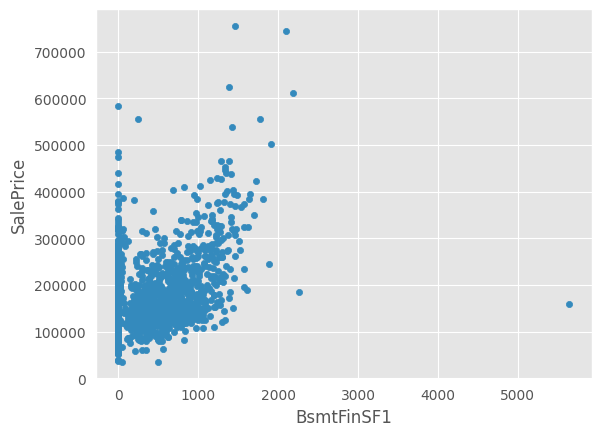

In [50]:
# BsmtFinSF1 と SalePrice の分布を可視化
df_all.plot.scatter(x="BsmtFinSF1", y="SalePrice")

- 0 のものがある程度ある。
- BsmtFinSF1 が広いほど SalePrice が高くなる傾向

異様に BsmtFinSF1 が広いものの、SalePrice が高くないものがあるので調査してみる。

In [51]:
# BsmtFinSF1 が広いものの SalePrice が高くないものを確認
df_all[df_all["BsmtFinSF1"] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

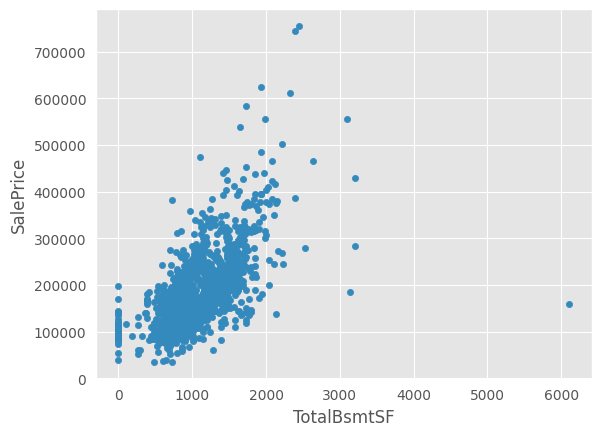

In [52]:
# TotalBsmtSF と SalePrice の分布を可視化
df_all.plot.scatter(x="TotalBsmtSF", y="SalePrice")

In [53]:
df_all[df_all["TotalBsmtSF"] > 6000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

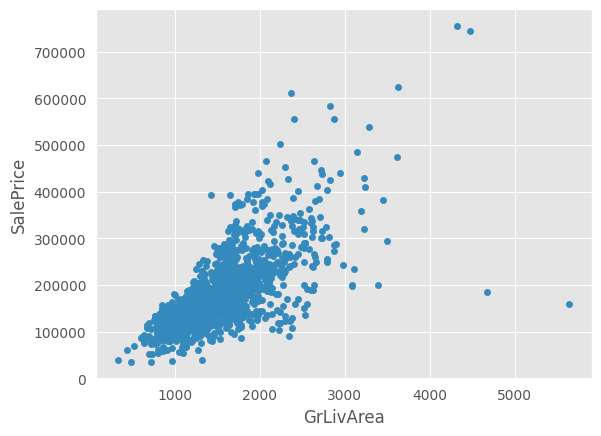

In [54]:
# GrLivArea と SalePrice の分布を可視化
df_all.plot.scatter(x="GrLivArea", y="SalePrice")

In [55]:
df_all[df_all["GrLivArea"] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


<Axes: xlabel='1stFlrSF', ylabel='SalePrice'>

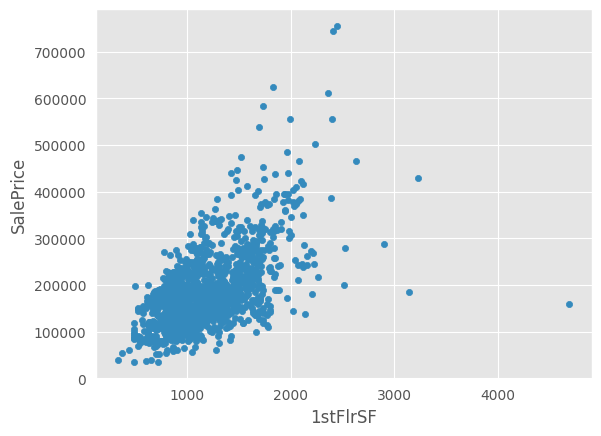

In [56]:
# 1stFlrSF と SalePrice の分布を可視化
df_all.plot.scatter(x="1stFlrSF", y="SalePrice")

In [57]:
df_all[df_all["1stFlrSF"] > 4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


ごく少数の Data では各変数の値が大きいものの目的変数が低い様子。
閾値を設けて、外れ値を除外することにする。
※Test-data は除外すると予測できなくなるので除外しないように注意。

In [58]:
# 外れ値以外を抽出（Test-data はすべて抽出）
df_all = df_all[(df_all["BsmtFinSF1"] < 2000) | (df_all["SalePrice"].isnull())]
df_all = df_all[(df_all["TotalBsmtSF"] < 3000) | (df_all["SalePrice"].isnull())]
df_all = df_all[(df_all["GrLivArea"] < 4500) | (df_all["SalePrice"].isnull())]
df_all = df_all[(df_all["1stFlrSF"] < 2500) | (df_all["SalePrice"].isnull())]
df_all = df_all[(df_all["LotArea"] < 100000) | (df_all["SalePrice"].isnull())]

### 前処理した学習Data で RMSE を計算する

In [59]:
# categories の仲から除外した３つの変数を削除
categories = categories.drop(["PoolQC", "MiscFeature", "Alley"])

In [60]:
# 欠損値を missing に置換して df_all の Category変数を category に指定
for cat in categories:
    le = LabelEncoder()

    print(cat)

    df_all[cat].fillna("missing", inplace=True)
    le = le.fit(df_all[cat])
    df_all[cat] = le.transform(df_all[cat])
    df_all[cat] = df_all[cat].astype("category")

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
Fence
SaleType
SaleCondition


In [61]:
# df_train_le と df_test_le に分割
df_train_le = df_all[~df_all["SalePrice"].isnull()]
df_test_le = df_all[df_all["SalePrice"].isnull()]

df_train_le["SalePrice_log"] = np.log(df_train_le["SalePrice"])  # SalePrice の対数をとる
train_X = df_train_le.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)
train_Y = df_train_le["SalePrice_log"]

In [62]:
model = []
rmses_2 = []
out_of_fold = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                          )

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models.append(model_lgb)
    rmses_2.append(tmp_rmse)
    out_of_fold[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2949
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 72
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0423077
[20]	valid_0's l2: 0.0220026
[30]	valid_0's l2: 0.0175682
[40]	valid_0's l2: 0.0163798
[50]	valid_0's l2: 0.0162547
[60]	valid_0's l2: 0.0162622
[70]	valid_0's l2: 0.0162514
Early stopping, best iteration is:
[58]	valid_0's l2: 0.0161791
0.12719701309461978
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2943
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 72
[LightGBM] [Info] 

In [63]:
print(f"外れ値の処理実施前の予測精度: {sum(rmses_1)/len(rmses_1)}")
print(f"外れ値の処理後の予測精度: {sum(rmses_2)/len(rmses_2)}")

外れ値の処理実施前の予測精度: 0.13274830975285581
外れ値の処理後の予測精度: 0.12980648684291307


## 説明変数の確認: 特徴量を生成する
data_description.txt より 大きく Data分類すると
- 時間Data
- 広さData
- 設備数・許容数Data
- 品質・分類Data

がある。
説明変数が多いので、大きく Data分類し新しい特徴量を生成できないか整理する。

In [64]:
# 時間に関する変数の統計量を確認
df_all[["YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold"]].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,2904.000000,2904.000000,2745.000000,2904.000000
mean,1971.234504,1984.217975,1978.061202,2007.792011
std,30.319059,20.907346,25.600996,1.316366
min,1872.000000,1950.000000,1895.000000,2006.000000
25%,1953.000000,1965.000000,1960.000000,2007.000000
50%,1973.000000,1993.000000,1979.000000,2008.000000
75%,2001.000000,2004.000000,2002.000000,2009.000000
max,2010.000000,2010.000000,2207.000000,2010.000000


- あまりに古い
- 2010年以降
- 年数としておかしな桁

など、おかしな Data は含まれていない様子。

### 時間に関する変数を組み合わせて新たな特徴量を作成する
販売した年は、築何年経過していたかという特徴量を追加し、再度学習する。

In [65]:
# 特徴量を追加
df_all["Age"] = df_all["YrSold"] - df_all["YearBuilt"]

In [66]:
# 再学習
df_train_le = df_all[~df_all["SalePrice"].isnull()]
df_test_le = df_all[df_all["SalePrice"].isnull()]

df_train_le["SalePrice_log"] = np.log(df_train_le["SalePrice"])
train_X = df_train_le.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)
train_Y = df_train_le["SalePrice_log"]

In [67]:
models = []
rmses_3 = []
out_of_fold = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                          )

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models.append(model_lgb)
    rmses_3.append(tmp_rmse)
    out_of_fold[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3046
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 73
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.042401
[20]	valid_0's l2: 0.0217498
[30]	valid_0's l2: 0.0175187
[40]	valid_0's l2: 0.0162941
[50]	valid_0's l2: 0.0160985
[60]	valid_0's l2: 0.0160802
[70]	valid_0's l2: 0.0161142
[80]	valid_0's l2: 0.016149
Early stopping, best iteration is:
[68]	valid_0's l2: 0.0160466
0.12667526340999952
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3037
[LightGBM] [Info] Number of data points in the train set: 963, number of used feat

In [68]:
print(f"前回の精度: {sum(rmses_2)/len(rmses_2)}")
print(f"今回の精度: {sum(rmses_3)/len(rmses_3)}")

前回の精度: 0.12980648684291307
今回の精度: 0.1293956304169199


若干精度がよくなった。

### 広さ関連の変数から新たな特徴量を作成する

In [69]:
# 広さに関する変数の統計量を確認
df_all[["LotArea", "MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea",
        "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea",
        "LotFrontage"]].describe()

,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,LotFrontage
count,2904.000000,2882.000000,2903.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2425.000000
mean,9912.604683,101.191187,559.850499,1043.794006,1152.707300,336.355372,4.718664,1493.781336,471.632794,93.265840,47.226584,22.988636,2.615702,16.086777,1.907025,69.071340
std,5178.128224,177.804595,438.438879,420.008348,377.291394,427.355787,46.515308,491.149725,214.551791,125.855568,67.195477,64.055325,25.252464,56.245764,33.082892,22.662001
min,1300.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,7448.250000,0.000000,220.000000,791.500000,875.750000,0.000000,0.000000,1124.000000,319.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000
50%,9422.000000,0.000000,467.000000,988.000000,1080.000000,0.000000,0.000000,1441.000000,478.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,68.000000
75%,11503.000000,164.000000,802.500000,1296.000000,1381.250000,704.000000,0.000000,1739.250000,576.000000,168.000000,69.250000,0.000000,0.000000,0.000000,0.000000,80.000000
max,70761.000000,1600.000000,2336.000000,5095.000000,5095.000000,1872.000000,1064.000000,5095.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,313.000000


- LotArea は非常に広い家がある
- Porch がない家が多い

In [70]:
# 広さ関連の特徴量として「各階 Total の広さ」、「お風呂の数の合計」を追加
df_all["TotalSF"] = df_all["TotalBsmtSF"] + df_all["1stFlrSF"] + df_all["2ndFlrSF"]
df_all["Total_Bathrooms"] = df_all["FullBath"] + df_all["HalfBath"] + df_all["BsmtFullBath"] + df_all["BsmtHalfBath"]

In [71]:
# Porch の広さの合計も特徴量として追加
df_all["Total_PorchSF"] = df_all["WoodDeckSF"] + df_all["OpenPorchSF"] + df_all["EnclosedPorch"] + df_all["3SsnPorch"] + df_all["ScreenPorch"]

In [72]:
# Porch の広さの合計を Porch があるかないかの 0, 1 の値に変換
df_all["hasPorch"] = df_all["Total_PorchSF"].apply(lambda x: 1 if x > 0 else 0)
df_all.drop("Total_PorchSF", axis=1, inplace=True)

In [73]:
# 精度を確認
df_train_le = df_all[~df_all["SalePrice"].isnull()]
df_test_le = df_all[df_all["SalePrice"].isnull()]

df_train_le["SalePrice_log"] = np.log(df_train_le["SalePrice"])
train_X = df_train_le.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)
train_Y = df_train_le["SalePrice_log"]

In [74]:
models = []
rmses_4 = []
out_of_fold = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                          )

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models.append(model_lgb)
    rmses_4.append(tmp_rmse)
    out_of_fold[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3310
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 76
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0382198
[20]	valid_0's l2: 0.0195098
[30]	valid_0's l2: 0.0163133
[40]	valid_0's l2: 0.0155157
[50]	valid_0's l2: 0.0154576
[60]	valid_0's l2: 0.0155145
Early stopping, best iteration is:
[48]	valid_0's l2: 0.0154265
0.12420330159076379
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3300
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 76
[LightGBM] [Info] Start training from score 12.

In [75]:
print(f"前回の精度: {sum(rmses_3)/len(rmses_3)}")
print(f"今回の精度: {sum(rmses_4)/len(rmses_4)}")

前回の精度: 0.1293956304169199
今回の精度: 0.12715991602050294


精度の向上を確認

## Hyper-parameter を最適化する
ここまでは、Default の Hyper-parameter を実行していたが調整することを考える。

### Optuna の利用
- 複数の Hyper-parameter を同時い変更していくことが必要(※１つを変更するだけでは精度が向上しないことが多い。)
- いちいち手動、for文を使い総当たりで、いくつもの Hyper-parameter の値の組み合わせを Test するのは大変。

>**Optuna**
>Bayes最適化を用いた手法の中で、PFN により開発された Library.
>効果的な Hyper-parameter を効率的に選択してくれる。

In [76]:
import optuna

### Optuna の実装
1. はじめに Model の学習Flow および改善したい精度を定義する。
2. Model で調整したい Hyper-parameter, および探索範囲を記述する。
3. trial回数を決めて最適化を実行する。

In [77]:
# 学習Data, 検証Data を作成する
from sklearn.model_selection import train_test_split

# Data の分割を固定
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, random_state=1234, shuffle=False, stratify=None)

In [78]:
# Optuna で Hyper-parameter を最適化する
def objective(trial):
    params = {
        "objective": "regression",
        "random_seed": 1234,
        "learning_rate": 0.05,  # どれだけ１回の学習を次の学習に反映させるかを固定
        "n_estimators": 1000,  # 学習回数を固定

        "num_leaves": trial.suggest_int("num_leaves", 4, 64),
        "max_bin": trial.suggest_int("max_bin", 50, 200),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 0.9),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 16),
        "min_sum_hessian_in_leaf": trial.suggest_int("min_sum_hessian_in_leaf", 1, 10),
    }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(params, lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10, )

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))

    return score

In [79]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=50)
study.best_params

[I 2023-04-01 15:10:48,793] A new study created in memory with name: no-name-93851421-a89a-428e-899d-8c3c5aa6fd06


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0659468
[20]	valid_0's l2: 0.0360287
[30]	valid_0's l2: 0.0239196
[40]	valid_0's l2: 0.0183967
[50]	valid_0's l2: 0.0161611
[60]	valid_0's l2: 0.015461
[70]	valid_0's l2: 0.0148438
[80]	valid_0's l2: 0.0145826
[90]	valid_0's l2: 0.0144628
[100]	valid_0's l2: 0.0143176
[110]	valid_0's l2: 0.0142316
[120]	valid_0's l2: 0.0142159


[I 2023-04-01 15:10:50,084] Trial 0 finished with value: 0.11921948775949837 and parameters: {'num_leaves': 37, 'max_bin': 157, 'bagging_fraction': 0.7013816880358219, 'bagging_freq': 6, 'feature_fraction': 0.6118273996694523, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 0 with value: 0.11921948775949837.


[130]	valid_0's l2: 0.0142722
Early stopping, best iteration is:
[119]	valid_0's l2: 0.0142133
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3097
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2023-04-01 15:10:50,631] Trial 1 finished with value: 0.12012901418633554 and parameters: {'num_leaves': 58, 'max_bin': 195, 'bagging_fraction': 0.5917207594128888, 'bagging_freq': 8, 'feature_fraction': 0.6644474598764523, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.11921948775949837.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's l2: 0.0146264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2023-04-01 15:10:50,974] Trial 2 finished with value: 0.12243462195761394 and parameters: {'num_leaves': 8, 'max_bin': 63, 'bagging_fraction': 0.4101091987201629, 'bagging_freq': 9, 'feature_fraction': 0.7890783754749253, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.11921948775949837.


[70]	valid_0's l2: 0.0171541
[80]	valid_0's l2: 0.0162883
[90]	valid_0's l2: 0.0158127
[100]	valid_0's l2: 0.0154521
[110]	valid_0's l2: 0.0149976
[120]	valid_0's l2: 0.0150278
[130]	valid_0's l2: 0.0150877
Early stopping, best iteration is:
[113]	valid_0's l2: 0.0149902
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0641327
[20]	valid_0's l2: 0.034555
[30]	valid_0's l2: 0.0232564
[40]	valid_0's l2: 0.0185056
[50]	valid_0's l2: 0.0165158
[60]	valid_0's l2: 0.0155843
[70]	valid_0's l2: 0.0151748
[80]	valid_0's l2: 0.014894
[90]	valid_0's l2: 0.0148207
[100]	valid_0's l2: 0.0146971
[110]	valid_0's l2: 0.0146044
[12

[I 2023-04-01 15:10:51,727] Trial 3 finished with value: 0.11948763685441079 and parameters: {'num_leaves': 52, 'max_bin': 119, 'bagging_fraction': 0.7902645881432278, 'bagging_freq': 2, 'feature_fraction': 0.7199605106637619, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.11921948775949837.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2276
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


[I 2023-04-01 15:10:52,281] Trial 4 finished with value: 0.11621335807143589 and parameters: {'num_leaves': 35, 'max_bin': 112, 'bagging_fraction': 0.5322778060523135, 'bagging_freq': 8, 'feature_fraction': 0.6280751661082743, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.11621335807143589.


[10]	valid_0's l2: 0.066408
[20]	valid_0's l2: 0.0363539
[30]	valid_0's l2: 0.0242351
[40]	valid_0's l2: 0.0189323
[50]	valid_0's l2: 0.0162179
[60]	valid_0's l2: 0.0147991
[70]	valid_0's l2: 0.0143232
[80]	valid_0's l2: 0.0143152
[90]	valid_0's l2: 0.0142693
[100]	valid_0's l2: 0.0140259
[110]	valid_0's l2: 0.0140546
[120]	valid_0's l2: 0.0138189
[130]	valid_0's l2: 0.0137193
[140]	valid_0's l2: 0.0137243
[150]	valid_0's l2: 0.0135936
[160]	valid_0's l2: 0.0135242
[170]	valid_0's l2: 0.0135713
[180]	valid_0's l2: 0.0136351
Early stopping, best iteration is:
[161]	valid_0's l2: 0.0135055
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds

[I 2023-04-01 15:10:52,846] Trial 5 finished with value: 0.12288551018586137 and parameters: {'num_leaves': 41, 'max_bin': 142, 'bagging_fraction': 0.7084669984373785, 'bagging_freq': 10, 'feature_fraction': 0.7409101495517417, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.11621335807143589.


[100]	valid_0's l2: 0.0151961
[110]	valid_0's l2: 0.0152685
Early stopping, best iteration is:
[94]	valid_0's l2: 0.0151008
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1500
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0650692
[20]	valid_0's l2: 0.035213
[30]	valid_0's l2: 0.0235695
[40]	valid_0's l2: 0.0189368
[50]	valid_0's l2: 0.0171787
[60]	valid_0's l2: 0.0162984
[70]	valid_0's l2: 0.0160839
[80]	valid_0's l2: 0.0159674
[90]	valid_0's l2: 0.0157391
[100]	valid_0's l2: 0.0156661
[110]	valid_0's l2: 0.015579
[120]	valid_0's l2: 0.0154832
[130]	valid_0's l2: 0.0153392
[140]	valid_0's l2: 0.0153525
[150]	valid_0's l2: 0.0153259


[I 2023-04-01 15:10:53,752] Trial 6 finished with value: 0.12372288602804948 and parameters: {'num_leaves': 46, 'max_bin': 59, 'bagging_fraction': 0.7333833577228339, 'bagging_freq': 7, 'feature_fraction': 0.5051912805369205, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11621335807143589.


[160]	valid_0's l2: 0.0153393
[170]	valid_0's l2: 0.015381
Early stopping, best iteration is:
[152]	valid_0's l2: 0.0153074
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2554
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0685588
[20]	valid_0's l2: 0.0385705
[30]	valid_0's l2: 0.0262354
[40]	valid_0's l2: 0.0206248
[50]	valid_0's l2: 0.017847
[60]	valid_0's l2: 0.0167885
[70]	valid_0's l2: 0.0160365
[80]	valid_0's l2: 0.0157248
[90]	valid_0's l2: 0.0156422
[100]	valid_0's l2: 0.0155114


[I 2023-04-01 15:10:54,276] Trial 7 finished with value: 0.12325661836479344 and parameters: {'num_leaves': 26, 'max_bin': 136, 'bagging_fraction': 0.6193007567311601, 'bagging_freq': 10, 'feature_fraction': 0.45102240537401406, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.11621335807143589.


[110]	valid_0's l2: 0.0154175
[120]	valid_0's l2: 0.015317
[130]	valid_0's l2: 0.0151995
[140]	valid_0's l2: 0.0152626
[150]	valid_0's l2: 0.0152446
Early stopping, best iteration is:
[134]	valid_0's l2: 0.0151922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0653917
[20]	valid_0's l2: 0.0353138
[30]	valid_0's l2: 0.0236292
[40]	valid_0's l2: 0.0191997
[50]	valid_0's l2: 0.0170269
[60]	valid_0's l2: 0.0159562
[70]	valid_0's l2: 0.015702
[80]	valid_0's l2: 0.0155463
[90]	valid_0's l2: 0.0154414
[100]	valid_0's l2: 0.0153966
[110]	valid_0's l2: 0.0153345
[120]	valid_0's l2: 0.0152618


[I 2023-04-01 15:10:55,008] Trial 8 finished with value: 0.12320036839604202 and parameters: {'num_leaves': 43, 'max_bin': 88, 'bagging_fraction': 0.6331553864281532, 'bagging_freq': 3, 'feature_fraction': 0.4794847918227599, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143589.


[130]	valid_0's l2: 0.015293
[140]	valid_0's l2: 0.0152435
[150]	valid_0's l2: 0.0152064
[160]	valid_0's l2: 0.0151995
[170]	valid_0's l2: 0.0152254
Early stopping, best iteration is:
[159]	valid_0's l2: 0.0151783
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1819
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0720131
[20]	valid_0's l2: 0.0421651
[30]	valid_0's l2: 0.0286681
[40]	valid_0's l2: 0.0219793
[50]	valid_0's l2: 0.0183408
[60]	valid_0's l2: 0.0164611
[70]	valid_0's l2: 0.01556
[80]	valid_0's l2: 0.015073
[90]	valid_0's l2: 0.0147495
[100]	valid_0's l2: 0.0145849
[110]	valid_0's l2: 0.0144036


[I 2023-04-01 15:10:55,493] Trial 9 finished with value: 0.11833930321635737 and parameters: {'num_leaves': 12, 'max_bin': 79, 'bagging_fraction': 0.5843625853304821, 'bagging_freq': 9, 'feature_fraction': 0.44855063789653066, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.11621335807143589.


[120]	valid_0's l2: 0.014341
[130]	valid_0's l2: 0.0143924
[140]	valid_0's l2: 0.0141699
[150]	valid_0's l2: 0.014075
[160]	valid_0's l2: 0.0140664
[170]	valid_0's l2: 0.0140677
[180]	valid_0's l2: 0.0140645
Early stopping, best iteration is:
[164]	valid_0's l2: 0.0140042
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2368
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 80
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0645947
[20]	valid_0's l2: 0.0349
[30]	valid_0's l2: 0.0239167
[40]	valid_0's l2: 0.019325
[50]	valid_0's l2: 0.017922
[60]	valid_0's l2: 0.017351
[70]	valid_0's l2: 0.0171303
[80]	valid_0's l2: 0.0171538
[90]	valid_0's l2: 0.0170625
[100]	valid_0's l2: 0.0169556
[110]	valid_0's l2: 0.0169456
[120]	

[I 2023-04-01 15:10:56,501] Trial 10 finished with value: 0.12954354159298162 and parameters: {'num_leaves': 63, 'max_bin': 120, 'bagging_fraction': 0.8883805440951686, 'bagging_freq': 7, 'feature_fraction': 0.7696317896991509, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 4 with value: 0.11621335807143589.


[150]	valid_0's l2: 0.0167815
[160]	valid_0's l2: 0.0168289
[170]	valid_0's l2: 0.0168183
Early stopping, best iteration is:
[150]	valid_0's l2: 0.0167815
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 80
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0723296
[20]	valid_0's l2: 0.0424445
[30]	valid_0's l2: 0.0284022
[40]	valid_0's l2: 0.0222346
[50]	valid_0's l2: 0.0189382
[60]	valid_0's l2: 0.0171733
[70]	valid_0's l2: 0.0163607
[80]	valid_0's l2: 0.0154663
[90]	valid_0's l2: 0.0151567
[100]	valid_0's l2: 0.0149257
[110]	valid_0's l2: 0.0147376
[120]	valid_0's l2: 0.0145206
[130]	valid_0's l2: 0.0145659
[140]	valid_0's l2: 0.0145321
[150]	valid_0's l2: 0.014415

[I 2023-04-01 15:10:56,863] Trial 11 finished with value: 0.11983377452964888 and parameters: {'num_leaves': 11, 'max_bin': 94, 'bagging_fraction': 0.45936385947712205, 'bagging_freq': 4, 'feature_fraction': 0.607131497257335, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143589.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1987
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's l2: 0.0652096
[20]	valid_0's l2: 0.0355787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's l2: 0.0236788


[I 2023-04-01 15:10:57,362] Trial 12 finished with value: 0.12066129587078792 and parameters: {'num_leaves': 38, 'max_bin': 90, 'bagging_fraction': 0.6616240267333499, 'bagging_freq': 1, 'feature_fraction': 0.6879732477780897, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11621335807143589.


[40]	valid_0's l2: 0.0185916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's l2: 0.0165607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's l2: 0.0154825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's l2: 0.0149025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's l2: 0.0146989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's l2: 0.014613
[100]	valid_0's l2: 0.014646
[110]	valid_0's l2: 0.0146479
Early stopping, best iteration is:
[92]	valid_0's l2: 0.0145591
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000384 second

[I 2023-04-01 15:10:58,132] Trial 13 finished with value: 0.11995043834537973 and parameters: {'num_leaves': 44, 'max_bin': 69, 'bagging_fraction': 0.7581636020592828, 'bagging_freq': 3, 'feature_fraction': 0.49159568100355844, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.11621335807143589.


[190]	valid_0's l2: 0.0144799
Early stopping, best iteration is:
[171]	valid_0's l2: 0.0143881
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1344
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2023-04-01 15:10:58,623] Trial 14 finished with value: 0.11838665985794043 and parameters: {'num_leaves': 54, 'max_bin': 50, 'bagging_fraction': 0.7389082683981151, 'bagging_freq': 3, 'feature_fraction': 0.7675970110612975, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 3}. Best is trial 4 with value: 0.11621335807143589.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's l2: 0.0184655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2023-04-01 15:10:59,097] Trial 15 finished with value: 0.12249843914982216 and parameters: {'num_leaves': 39, 'max_bin': 139, 'bagging_fraction': 0.6861259528954367, 'bagging_freq': 3, 'feature_fraction': 0.8763745057584925, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.11621335807143589.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2047
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0654476
[20]	valid_0's l2: 0.0348945
[30]	valid_0's l2: 0.0232133
[40]	valid_0's l2: 0.0186158
[50]	valid_0's l2: 0.0167928
[60]	valid_0's l2: 0.0158671
[70]	valid_0's l2: 0.0151884
[80]	valid_0's l2: 0.014973
[90]	valid_0's l2: 0.0148574
[100]	valid_0's l2: 0.0147908
[110]	valid_0's l2: 0.0147467
[120]	valid_0's l2: 0.0147442


[I 2023-04-01 15:10:59,938] Trial 16 finished with value: 0.12079833209560323 and parameters: {'num_leaves': 46, 'max_bin': 94, 'bagging_fraction': 0.8068989098512387, 'bagging_freq': 4, 'feature_fraction': 0.8405515985555808, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.11621335807143589.


[130]	valid_0's l2: 0.0147911
[140]	valid_0's l2: 0.0146097
[150]	valid_0's l2: 0.0146298
[160]	valid_0's l2: 0.0146584
Early stopping, best iteration is:
[141]	valid_0's l2: 0.0145922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0635115
[20]	valid_0's l2: 0.0356727
[30]	valid_0's l2: 0.0241828
[40]	valid_0's l2: 0.0197761
[50]	valid_0's l2: 0.017458
[60]	valid_0's l2: 0.0164014
[70]	valid_0's l2: 0.0161523
[80]	valid_0's l2: 0.015674
[90]	valid_0's l2: 0.0155865
[100]	valid_0's l2: 0.0156389
Early stopping, best iteration is:
[85]	valid_0's l2: 0.0155394


[I 2023-04-01 15:11:00,499] Trial 17 finished with value: 0.12465732708852484 and parameters: {'num_leaves': 46, 'max_bin': 159, 'bagging_fraction': 0.6506621909633512, 'bagging_freq': 10, 'feature_fraction': 0.7219950996148188, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143589.
[I 2023-04-01 15:11:00,802] Trial 18 finished with value: 0.1196652805748072 and parameters: {'num_leaves': 5, 'max_bin': 95, 'bagging_fraction': 0.7300867687463426, 'bagging_freq': 3, 'feature_fraction': 0.7090077144994208, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.11621335807143589.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2060
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0772015
[20]	valid_0's l2: 0.0488641
[30]	valid_0's l2: 0.034581
[40]	valid_0's l2: 0.0270809
[50]	valid_0's l2: 0.0230393
[60]	valid_0's l2: 0.020913
[70]	valid_0's l2: 0.0198276
[80]	valid_0's l2: 0.018913
[90]	valid_0's l2: 0.0180636
[100]	valid_0's l2: 0.0173222
[110]	valid_0's l2: 0.0167365
[120]	valid_0's l2: 0.0162763
[130]	valid_0's l2: 0.016011
[140]	valid_0's l2: 0.0157394
[150]	valid_0's l2: 0.0154868
[160]	valid_0's l2: 0.0154228
[170]	valid_0's l2: 0.0153516
[180]	valid_0's l2: 0.0152941
[190]	valid_0's l2: 0.0150688
[200]	valid_0's l2: 0.0149567
[210]	v

[I 2023-04-01 15:11:01,896] Trial 19 finished with value: 0.12002938223871083 and parameters: {'num_leaves': 22, 'max_bin': 136, 'bagging_fraction': 0.6954363806240866, 'bagging_freq': 6, 'feature_fraction': 0.7266004099285668, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.11621335807143589.


[10]	valid_0's l2: 0.0666045
[20]	valid_0's l2: 0.037398
[30]	valid_0's l2: 0.0252309
[40]	valid_0's l2: 0.0194101
[50]	valid_0's l2: 0.016904
[60]	valid_0's l2: 0.0160305
[70]	valid_0's l2: 0.0153439
[80]	valid_0's l2: 0.0148304
[90]	valid_0's l2: 0.0147109
[100]	valid_0's l2: 0.0145076
[110]	valid_0's l2: 0.0145036
[120]	valid_0's l2: 0.0144584
[130]	valid_0's l2: 0.0144166
[140]	valid_0's l2: 0.0145413
[150]	valid_0's l2: 0.0145218
Early stopping, best iteration is:
[131]	valid_0's l2: 0.014407
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2182
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warn

[I 2023-04-01 15:11:02,319] Trial 20 finished with value: 0.12442620993318668 and parameters: {'num_leaves': 58, 'max_bin': 105, 'bagging_fraction': 0.6179324626328134, 'bagging_freq': 9, 'feature_fraction': 0.8030969945230428, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.11621335807143589.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's l2: 0.015726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2023-04-01 15:11:02,978] Trial 21 finished with value: 0.12718774119423698 and parameters: {'num_leaves': 60, 'max_bin': 157, 'bagging_fraction': 0.8994235032839333, 'bagging_freq': 2, 'feature_fraction': 0.8340630286841071, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143589.


Early stopping, best iteration is:
[117]	valid_0's l2: 0.0161767
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3017
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0717053
[20]	valid_0's l2: 0.0413166
[30]	valid_0's l2: 0.0279717
[40]	valid_0's l2: 0.0219095
[50]	valid_0's l2: 0.0189611
[60]	valid_0's l2: 0.0172604
[70]	valid_0's l2: 0.0164715
[80]	valid_0's l2: 0.0160482


[I 2023-04-01 15:11:03,298] Trial 22 finished with value: 0.12151261222488925 and parameters: {'num_leaves': 11, 'max_bin': 178, 'bagging_fraction': 0.8036594793625054, 'bagging_freq': 6, 'feature_fraction': 0.6035916486129999, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143589.


[90]	valid_0's l2: 0.0157468
[100]	valid_0's l2: 0.0153786
[110]	valid_0's l2: 0.0151728
[120]	valid_0's l2: 0.0149921
[130]	valid_0's l2: 0.0149268
[140]	valid_0's l2: 0.0148403
[150]	valid_0's l2: 0.0148404
Early stopping, best iteration is:
[137]	valid_0's l2: 0.0147653
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2831
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 80
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0656779
[20]	valid_0's l2: 0.0362675
[30]	valid_0's l2: 0.0243702
[40]	valid_0's l2: 0.019556
[50]	valid_0's l2: 0.0175464
[60]	valid_0's l2: 0.0166221
[70]	valid_0's l2: 0.016172
[80]	valid_0's l2: 0.0160095
[90]	valid_0's l2: 0.015721
[100]	valid_0's l2: 0.0155644
[110]	valid_0's l2: 0.0154965
[1

[I 2023-04-01 15:11:04,284] Trial 23 finished with value: 0.12286137283920079 and parameters: {'num_leaves': 31, 'max_bin': 159, 'bagging_fraction': 0.8331911629643146, 'bagging_freq': 10, 'feature_fraction': 0.8279016711963055, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11621335807143589.


Early stopping, best iteration is:
[214]	valid_0's l2: 0.0150949
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 80
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0666495
[20]	valid_0's l2: 0.0366255
[30]	valid_0's l2: 0.0251371
[40]	valid_0's l2: 0.0201572


[I 2023-04-01 15:11:04,940] Trial 24 finished with value: 0.12562753706931873 and parameters: {'num_leaves': 48, 'max_bin': 75, 'bagging_fraction': 0.6605183031020647, 'bagging_freq': 1, 'feature_fraction': 0.49999826244820006, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.11621335807143589.


[50]	valid_0's l2: 0.0179482
[60]	valid_0's l2: 0.0167342
[70]	valid_0's l2: 0.0163499
[80]	valid_0's l2: 0.0159761
[90]	valid_0's l2: 0.0157986
[100]	valid_0's l2: 0.0158269
[110]	valid_0's l2: 0.015862
Early stopping, best iteration is:
[91]	valid_0's l2: 0.0157823
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2158
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0688781
[20]	valid_0's l2: 0.0382244
[30]	valid_0's l2: 0.0256253
[40]	valid_0's l2: 0.0200546
[50]	valid_0's l2: 0.0173239
[60]	valid_0's l2: 0.0160902
[70]	valid_0's l2: 0.0154621
[80]	valid_0's l2: 0.0150493
[90]	valid_0's l2: 0.0148306
[100]	valid_0's l2: 0.0145364
[110]	valid_0's l2: 0.0144797
[120]

[I 2023-04-01 15:11:05,542] Trial 25 finished with value: 0.11805245762386345 and parameters: {'num_leaves': 17, 'max_bin': 102, 'bagging_fraction': 0.8640406467327955, 'bagging_freq': 8, 'feature_fraction': 0.41591946476565395, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143589.


[180]	valid_0's l2: 0.0139826
[190]	valid_0's l2: 0.014061
Early stopping, best iteration is:
[177]	valid_0's l2: 0.0139364
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0648772
[20]	valid_0's l2: 0.0348522
[30]	valid_0's l2: 0.0229095
[40]	valid_0's l2: 0.0183481
[50]	valid_0's l2: 0.0164278
[60]	valid_0's l2: 0.0157691
[70]	valid_0's l2: 0.0153027
[80]	valid_0's l2: 0.0150543
[90]	valid_0's l2: 0.0150916


[I 2023-04-01 15:11:06,084] Trial 26 finished with value: 0.12254068874515264 and parameters: {'num_leaves': 39, 'max_bin': 85, 'bagging_fraction': 0.867106998962397, 'bagging_freq': 7, 'feature_fraction': 0.6678164015124792, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.11621335807143589.


[100]	valid_0's l2: 0.0152523
Early stopping, best iteration is:
[85]	valid_0's l2: 0.0150162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.066821
[20]	valid_0's l2: 0.0369266
[30]	valid_0's l2: 0.024767
[40]	valid_0's l2: 0.0192622
[50]	valid_0's l2: 0.0169376


[I 2023-04-01 15:11:06,460] Trial 27 finished with value: 0.11930966687202052 and parameters: {'num_leaves': 23, 'max_bin': 110, 'bagging_fraction': 0.5049218744875611, 'bagging_freq': 2, 'feature_fraction': 0.8721861949919668, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.11621335807143589.


[60]	valid_0's l2: 0.0157414
[70]	valid_0's l2: 0.0150072
[80]	valid_0's l2: 0.0146723
[90]	valid_0's l2: 0.0143443
[100]	valid_0's l2: 0.0143655
[110]	valid_0's l2: 0.0142893
Early stopping, best iteration is:
[95]	valid_0's l2: 0.0142348
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0689996
[20]	valid_0's l2: 0.0393946
[30]	valid_0's l2: 0.026756
[40]	valid_0's l2: 0.0207262


[I 2023-04-01 15:11:06,954] Trial 28 finished with value: 0.11905735001190403 and parameters: {'num_leaves': 17, 'max_bin': 88, 'bagging_fraction': 0.42901458016193783, 'bagging_freq': 5, 'feature_fraction': 0.5558979409970513, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11621335807143589.


[50]	valid_0's l2: 0.0181382
[60]	valid_0's l2: 0.0163805
[70]	valid_0's l2: 0.0155477
[80]	valid_0's l2: 0.0151918
[90]	valid_0's l2: 0.0149329
[100]	valid_0's l2: 0.0144812
[110]	valid_0's l2: 0.0143082
[120]	valid_0's l2: 0.0142451
[130]	valid_0's l2: 0.0142627
Early stopping, best iteration is:
[114]	valid_0's l2: 0.0141747
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1396
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0686203
[20]	valid_0's l2: 0.0388643
[30]	valid_0's l2: 0.0264241
[40]	valid_0's l2: 0.0202205
[50]	valid_0's l2: 0.0174781
[60]	valid_0's l2: 0.015947
[70]	valid_0's l2: 0.015287

[I 2023-04-01 15:11:07,267] Trial 29 finished with value: 0.11689738493077201 and parameters: {'num_leaves': 14, 'max_bin': 53, 'bagging_fraction': 0.4336248157316243, 'bagging_freq': 7, 'feature_fraction': 0.6268484222780226, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.11621335807143589.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1863
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2023-04-01 15:11:08,204] Trial 30 finished with value: 0.11621005960781597 and parameters: {'num_leaves': 64, 'max_bin': 82, 'bagging_fraction': 0.7315391015500504, 'bagging_freq': 3, 'feature_fraction': 0.41032549973286436, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 4}. Best is trial 30 with value: 0.11621005960781597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's l2: 0.0136354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[181]	valid_0's l2: 0.0135048
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0662191
[20]	valid_0's l2: 0.0375317
[30]	valid_0's l2: 0.0249813
[40]	valid_0's l2: 0.0196436
[50]	valid_0's l2: 0.0175243
[60]	valid_0's l2: 0.016674
[70]	valid_0's l2: 0.0161567
[80]	valid_0's l2: 0.0160406
[90]	valid_0's l2: 0.0159134
[100]	valid_0's l2: 0.0157352
[110]	valid_0's l2: 0.0156062
[120]	valid_0's l2: 0.0154926

[I 2023-04-01 15:11:08,907] Trial 31 finished with value: 0.12345973724558294 and parameters: {'num_leaves': 27, 'max_bin': 138, 'bagging_fraction': 0.8155242276180952, 'bagging_freq': 7, 'feature_fraction': 0.8363253277236977, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 8}. Best is trial 30 with value: 0.11621005960781597.


[160]	valid_0's l2: 0.0153489
[170]	valid_0's l2: 0.0153372
Early stopping, best iteration is:
[154]	valid_0's l2: 0.0152423
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3081
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0687108
[20]	valid_0's l2: 0.039362
[30]	valid_0's l2: 0.0268704
[40]	valid_0's l2: 0.0213277
[50]	valid_0's l2: 0.0185501


[I 2023-04-01 15:11:09,416] Trial 32 finished with value: 0.12450060870067972 and parameters: {'num_leaves': 15, 'max_bin': 193, 'bagging_fraction': 0.7437441381939076, 'bagging_freq': 3, 'feature_fraction': 0.8736852952444621, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 3}. Best is trial 30 with value: 0.11621005960781597.


[60]	valid_0's l2: 0.0172349
[70]	valid_0's l2: 0.0165869
[80]	valid_0's l2: 0.0160938
[90]	valid_0's l2: 0.016112
[100]	valid_0's l2: 0.0158469
[110]	valid_0's l2: 0.0156173
[120]	valid_0's l2: 0.0155477
[130]	valid_0's l2: 0.01557
[140]	valid_0's l2: 0.0155486
[150]	valid_0's l2: 0.0155581
[160]	valid_0's l2: 0.0155437
Early stopping, best iteration is:
[144]	valid_0's l2: 0.0155004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2459
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0682726
[20]	valid_0's l2: 0.0384307
[30]	valid_0's l2: 0.0260289
[40]	valid_0's l2: 0.0204018
[50]	valid_0's l2: 0.0177781
[60]	valid_0's l2: 0.0165407
[70]	valid_0's l2: 0.0158151
[80

[I 2023-04-01 15:11:09,944] Trial 33 finished with value: 0.12071985685535162 and parameters: {'num_leaves': 17, 'max_bin': 128, 'bagging_fraction': 0.4128313590272658, 'bagging_freq': 3, 'feature_fraction': 0.6123427343757532, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 30 with value: 0.11621005960781597.


[150]	valid_0's l2: 0.014627
[160]	valid_0's l2: 0.0146223
[170]	valid_0's l2: 0.0146368
Early stopping, best iteration is:
[153]	valid_0's l2: 0.0145733
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2580
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0676655
[20]	valid_0's l2: 0.0383163
[30]	valid_0's l2: 0.0259987
[40]	valid_0's l2: 0.0205822
[50]	valid_0's l2: 0.0179582
[60]	valid_0's l2: 0.0165008
[70]	valid_0's l2: 0.0159439
[80]	valid_0's l2: 0.0154322
[90]	valid_0's l2: 0.0152
[100]	valid_0's l2: 0.0150601
[110]	valid_0's l2: 0.0149015
[120]	valid_0's l2: 0.0147122
[130]	valid_0's l2: 0.0146916
[140]	valid_0's l2: 0.0146432
[150]	valid_0's l2: 0.0145681
[1

[I 2023-04-01 15:11:10,569] Trial 34 finished with value: 0.1203595765461759 and parameters: {'num_leaves': 20, 'max_bin': 138, 'bagging_fraction': 0.8319278029616157, 'bagging_freq': 2, 'feature_fraction': 0.6586895535770572, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 30 with value: 0.11621005960781597.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2542
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.068393
[20]	valid_0's l2: 0.0381795
[30]	valid_0's l2: 0.0252867
[40]	valid_0's l2: 0.0199694
[50]	valid_0's l2: 0.017562
[60]	valid_0's l2: 0.0163758
[70]	valid_0's l2: 0.0155249
[80]	valid_0's l2: 0.0149318
[90]	valid_0's l2: 0.0147414
[100]	valid_0's l2: 0.0146293


[I 2023-04-01 15:11:10,975] Trial 35 finished with value: 0.12059170214927309 and parameters: {'num_leaves': 28, 'max_bin': 135, 'bagging_fraction': 0.49163991810703933, 'bagging_freq': 2, 'feature_fraction': 0.6440281403244773, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 10}. Best is trial 30 with value: 0.11621005960781597.


[110]	valid_0's l2: 0.0146798
[120]	valid_0's l2: 0.0146872
Early stopping, best iteration is:
[105]	valid_0's l2: 0.0145424
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2870
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.064695
[20]	valid_0's l2: 0.0350467
[30]	valid_0's l2: 0.0236307
[40]	valid_0's l2: 0.0190976
[50]	valid_0's l2: 0.0170016
[60]	valid_0's l2: 0.0162354
[70]	valid_0's l2: 0.0158601
[80]	valid_0's l2: 0.0156705
[90]	valid_0's l2: 0.0155466
[100]	valid_0's l2: 0.0154278
[110]	valid_0's l2: 0.0153874
[120]	valid_0's l2: 0.0153315


[I 2023-04-01 15:11:12,032] Trial 36 finished with value: 0.12362844403791995 and parameters: {'num_leaves': 50, 'max_bin': 163, 'bagging_fraction': 0.8518598698729667, 'bagging_freq': 1, 'feature_fraction': 0.6760962349612033, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 30 with value: 0.11621005960781597.


[130]	valid_0's l2: 0.0153339
[140]	valid_0's l2: 0.0153313
[150]	valid_0's l2: 0.0153087
[160]	valid_0's l2: 0.0153258
Early stopping, best iteration is:
[145]	valid_0's l2: 0.015284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0677306
[20]	valid_0's l2: 0.0370913
[30]	valid_0's l2: 0.0243411
[40]	valid_0's l2: 0.0191862
[50]	valid_0's l2: 0.0167617


[I 2023-04-01 15:11:15,308] Trial 37 finished with value: 0.11634589292845096 and parameters: {'num_leaves': 21, 'max_bin': 86, 'bagging_fraction': 0.45014697113274893, 'bagging_freq': 1, 'feature_fraction': 0.8647646583960953, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 8}. Best is trial 30 with value: 0.11621005960781597.


[60]	valid_0's l2: 0.0155816
[70]	valid_0's l2: 0.0147963
[80]	valid_0's l2: 0.0142493
[90]	valid_0's l2: 0.0141046
[100]	valid_0's l2: 0.01402
[110]	valid_0's l2: 0.01378
[120]	valid_0's l2: 0.013896
[130]	valid_0's l2: 0.0137337
[140]	valid_0's l2: 0.0136708
[150]	valid_0's l2: 0.013656
[160]	valid_0's l2: 0.0135364
[170]	valid_0's l2: 0.0136163
[180]	valid_0's l2: 0.013646
Early stopping, best iteration is:
[160]	valid_0's l2: 0.0135364
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


[I 2023-04-01 15:11:15,736] Trial 38 finished with value: 0.12190846996739749 and parameters: {'num_leaves': 21, 'max_bin': 138, 'bagging_fraction': 0.4319776330604906, 'bagging_freq': 5, 'feature_fraction': 0.8887475698722234, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 30 with value: 0.11621005960781597.


[10]	valid_0's l2: 0.0683957
[20]	valid_0's l2: 0.0389712
[30]	valid_0's l2: 0.0265129
[40]	valid_0's l2: 0.0206742
[50]	valid_0's l2: 0.0187495
[60]	valid_0's l2: 0.0173362
[70]	valid_0's l2: 0.0164796
[80]	valid_0's l2: 0.0159671
[90]	valid_0's l2: 0.0157594
[100]	valid_0's l2: 0.0153507
[110]	valid_0's l2: 0.0150858
[120]	valid_0's l2: 0.014961
[130]	valid_0's l2: 0.01496
[140]	valid_0's l2: 0.0148748
[150]	valid_0's l2: 0.014995
[160]	valid_0's l2: 0.0149387
Early stopping, best iteration is:
[141]	valid_0's l2: 0.0148617
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1896
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 round

[I 2023-04-01 15:11:16,476] Trial 39 finished with value: 0.12215065383271785 and parameters: {'num_leaves': 62, 'max_bin': 84, 'bagging_fraction': 0.8746594112078407, 'bagging_freq': 10, 'feature_fraction': 0.7996012936761958, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 30 with value: 0.11621005960781597.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3017
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.067131
[20]	valid_0's l2: 0.037303
[30]	valid_0's l2: 0.0249732
[40]	valid_0's l2: 0.0195751
[50]	valid_0's l2: 0.0168822
[60]	valid_0's l2: 0.0154761
[70]	valid_0's l2: 0.0148505
[80]	valid_0's l2: 0.0144755
[90]	valid_0's l2: 0.014292
[100]	valid_0's l2: 0.0141133
[110]	valid_0's l2: 0.0140325
[120]	valid_0's l2: 0.0138918
[130]	valid_0's l2: 0.0138017
[140]	valid_0's l2: 0.0137878


[I 2023-04-01 15:11:17,132] Trial 40 finished with value: 0.11702331907533091 and parameters: {'num_leaves': 21, 'max_bin': 178, 'bagging_fraction': 0.7089383459587619, 'bagging_freq': 1, 'feature_fraction': 0.5736167589661099, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 30 with value: 0.11621005960781597.


[150]	valid_0's l2: 0.0137468
[160]	valid_0's l2: 0.0137043
[170]	valid_0's l2: 0.0137
[180]	valid_0's l2: 0.0137556
Early stopping, best iteration is:
[161]	valid_0's l2: 0.0136945
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2424
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0680019
[20]	valid_0's l2: 0.0374251
[30]	valid_0's l2: 0.0246349
[40]	valid_0's l2: 0.019427
[50]	valid_0's l2: 0.0167085
[60]	valid_0's l2: 0.0151676
[70]	valid_0's l2: 0.014551
[80]	valid_0's l2: 0.0141983


[I 2023-04-01 15:11:18,100] Trial 41 finished with value: 0.11607389645958349 and parameters: {'num_leaves': 33, 'max_bin': 125, 'bagging_fraction': 0.7197362581993618, 'bagging_freq': 4, 'feature_fraction': 0.4684501358427995, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 2}. Best is trial 41 with value: 0.11607389645958349.


[90]	valid_0's l2: 0.0139977
[100]	valid_0's l2: 0.0139503
[110]	valid_0's l2: 0.0138424
[120]	valid_0's l2: 0.0136913
[130]	valid_0's l2: 0.0136268
[140]	valid_0's l2: 0.0135483
[150]	valid_0's l2: 0.0134731
[160]	valid_0's l2: 0.0135188
[170]	valid_0's l2: 0.0135685
Early stopping, best iteration is:
[150]	valid_0's l2: 0.0134731
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1876
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2023-04-01 15:11:18,635] Trial 42 finished with value: 0.1236050938904355 and parameters: {'num_leaves': 35, 'max_bin': 83, 'bagging_fraction': 0.44892224224701704, 'bagging_freq': 9, 'feature_fraction': 0.8864597445115652, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 10}. Best is trial 41 with value: 0.11607389645958349.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's l2: 0.0160407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2023-04-01 15:11:19,213] Trial 43 finished with value: 0.12258004859678506 and parameters: {'num_leaves': 51, 'max_bin': 100, 'bagging_fraction': 0.4405506949939984, 'bagging_freq': 5, 'feature_fraction': 0.5161170710854714, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 1}. Best is trial 41 with value: 0.11607389645958349.


[20]	valid_0's l2: 0.0369944
[30]	valid_0's l2: 0.0252167
[40]	valid_0's l2: 0.0195319
[50]	valid_0's l2: 0.0176001
[60]	valid_0's l2: 0.0164878
[70]	valid_0's l2: 0.0160626
[80]	valid_0's l2: 0.0157654
[90]	valid_0's l2: 0.0154859
[100]	valid_0's l2: 0.0151975
[110]	valid_0's l2: 0.0150395
[120]	valid_0's l2: 0.0150358
Early stopping, best iteration is:
[107]	valid_0's l2: 0.0150259
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1364
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0671077
[20]	valid_0's l2: 0.0359559
[30]	valid_0's l2: 0.0239904
[40]	valid_0's l2: 0.0189382


[I 2023-04-01 15:11:19,745] Trial 44 finished with value: 0.1184374572828425 and parameters: {'num_leaves': 48, 'max_bin': 51, 'bagging_fraction': 0.7852903742513881, 'bagging_freq': 2, 'feature_fraction': 0.4397610412933779, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 41 with value: 0.11607389645958349.


[50]	valid_0's l2: 0.0167995
[60]	valid_0's l2: 0.0154498
[70]	valid_0's l2: 0.0148961
[80]	valid_0's l2: 0.0147326
[90]	valid_0's l2: 0.0146315
[100]	valid_0's l2: 0.014387
[110]	valid_0's l2: 0.014218
[120]	valid_0's l2: 0.0140993
[130]	valid_0's l2: 0.0140685
[140]	valid_0's l2: 0.0140959
Early stopping, best iteration is:
[126]	valid_0's l2: 0.0140274
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2289
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0676824
[20]	valid_0's l2: 0.0391645
[30]	valid_0's l2: 0.0265916
[40]	valid_0's l2: 0.0210271
[50]	valid_0's l2: 0.0183889
[60]	valid_0's l2: 0.01707
[70]	valid_0's l2: 0.0163417
[80]	valid_0's l2: 0.0159728
[90]	v

[I 2023-04-01 15:11:20,253] Trial 45 finished with value: 0.12306701064230104 and parameters: {'num_leaves': 18, 'max_bin': 113, 'bagging_fraction': 0.6786843956619585, 'bagging_freq': 9, 'feature_fraction': 0.7635221313556642, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 41 with value: 0.11607389645958349.


[120]	valid_0's l2: 0.0152131
[130]	valid_0's l2: 0.0151542
Early stopping, best iteration is:
[117]	valid_0's l2: 0.0151455
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2060
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0736703
[20]	valid_0's l2: 0.0446699
[30]	valid_0's l2: 0.0309675
[40]	valid_0's l2: 0.0240148
[50]	valid_0's l2: 0.0205786
[60]	valid_0's l2: 0.0184582
[70]	valid_0's l2: 0.0172221
[80]	valid_0's l2: 0.0162455
[90]	valid_0's l2: 0.0157497
[100]	valid_0's l2: 0.0152315
[110]	valid_0's l2: 0.0152008
[120]	valid_0's l2: 0.0152169
[130]	valid_0's l2: 0.0149349
[140]	valid_0's l2: 0.01

[I 2023-04-01 15:11:20,669] Trial 46 finished with value: 0.12049687664013226 and parameters: {'num_leaves': 7, 'max_bin': 95, 'bagging_fraction': 0.5310590746198391, 'bagging_freq': 5, 'feature_fraction': 0.7416406677738403, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 3}. Best is trial 41 with value: 0.11607389645958349.


[150]	valid_0's l2: 0.0146566
[160]	valid_0's l2: 0.0145811
[170]	valid_0's l2: 0.0146407
[180]	valid_0's l2: 0.0145551
[190]	valid_0's l2: 0.0145977
[200]	valid_0's l2: 0.0145908
Early stopping, best iteration is:
[185]	valid_0's l2: 0.0145195
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1789
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0664059
[20]	valid_0's l2: 0.0364447
[30]	valid_0's l2: 0.0245169
[40]	valid_0's l2: 0.0195329
[50]	valid_0's l2: 0.0173828
[60]	valid_0's l2: 0.0164353
[70]	valid_0's l2: 0.0157514
[80]	valid_0's l2: 0.0153623
[90]	valid_0's l2: 0.015229
[100]	valid_0's l2: 0.0151322
[110]	valid_0's l2: 0.0149309
[120]	valid_0's l2: 0.0148238

[I 2023-04-01 15:11:21,226] Trial 47 finished with value: 0.12172000179946448 and parameters: {'num_leaves': 27, 'max_bin': 77, 'bagging_fraction': 0.7942727561532594, 'bagging_freq': 1, 'feature_fraction': 0.7484986208624937, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 41 with value: 0.11607389645958349.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2198
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0674904
[20]	valid_0's l2: 0.0378495
[30]	valid_0's l2: 0.0253106
[40]	valid_0's l2: 0.0199075
[50]	valid_0's l2: 0.0172684
[60]	valid_0's l2: 0.0158523
[70]	valid_0's l2: 0.0153712
[80]	valid_0's l2: 0.0151057
[90]	valid_0's l2: 0.0150663
[100]	valid_0's l2: 0.014961
[110]	valid_0's l2: 0.0148236


[I 2023-04-01 15:11:21,912] Trial 48 finished with value: 0.12038292521465738 and parameters: {'num_leaves': 19, 'max_bin': 106, 'bagging_fraction': 0.6937998175981945, 'bagging_freq': 3, 'feature_fraction': 0.5854263996089444, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 41 with value: 0.11607389645958349.


[120]	valid_0's l2: 0.0147344
[130]	valid_0's l2: 0.0146849
[140]	valid_0's l2: 0.014542
[150]	valid_0's l2: 0.0146394
[160]	valid_0's l2: 0.0146166
Early stopping, best iteration is:
[144]	valid_0's l2: 0.014492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2940
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0762818
[20]	valid_0's l2: 0.0467362
[30]	valid_0's l2: 0.03249
[40]	valid_0's l2: 0.0257868
[50]	valid_0's l2: 0.0214988
[60]	valid_0's l2: 0.0193962


[I 2023-04-01 15:11:22,490] Trial 49 finished with value: 0.11848287385526714 and parameters: {'num_leaves': 6, 'max_bin': 170, 'bagging_fraction': 0.4384782234933164, 'bagging_freq': 6, 'feature_fraction': 0.5534050497725981, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 41 with value: 0.11607389645958349.


[70]	valid_0's l2: 0.0180176
[80]	valid_0's l2: 0.0166924
[90]	valid_0's l2: 0.015955
[100]	valid_0's l2: 0.0155308
[110]	valid_0's l2: 0.0151824
[120]	valid_0's l2: 0.0147177
[130]	valid_0's l2: 0.0146438
[140]	valid_0's l2: 0.0145239
[150]	valid_0's l2: 0.014505
[160]	valid_0's l2: 0.0145101
[170]	valid_0's l2: 0.0143538
[180]	valid_0's l2: 0.0142652
[190]	valid_0's l2: 0.0142552
[200]	valid_0's l2: 0.0142293
[210]	valid_0's l2: 0.0140382
[220]	valid_0's l2: 0.0142292
[230]	valid_0's l2: 0.0141861
Early stopping, best iteration is:
[210]	valid_0's l2: 0.0140382


{'num_leaves': 33,
 'max_bin': 125,
 'bagging_fraction': 0.7197362581993618,
 'bagging_freq': 4,
 'feature_fraction': 0.4684501358427995,
 'min_data_in_leaf': 14,
 'min_sum_hessian_in_leaf': 2}

50回の施行内でもっとも精度の高かった Hyper-parameter を確認。

In [80]:
# 得られた Hyper-parameter を設定して Cross-validation
lgbm_params = {
    "objective": "regression",
    "random_seed": 1234,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "num_leaves": 33,
    "bagging_fraction": 0.7197362581993618,
    "bagging_freq": 4,
    "feature_fraction": 0.4684501358427995,
    "min_data_in_leaf": 14,
    "min_sum_hessian_in_leaf": 2
}

In [81]:
models = []
rmses_5 = []
out_of_fold = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                          )

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models.append(model_lgb)
    rmses_5.append(tmp_rmse)
    out_of_fold[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3316
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 77
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0729239
[20]	valid_0's l2: 0.0394397
[30]	valid_0's l2: 0.0261091
[40]	valid_0's l2: 0.019779
[50]	valid_0's l2: 0.0167449
[60]	valid_0's l2: 0.0153771
[70]	valid_0's l2: 0.0146458
[80]	valid_0's l2: 0.0140797
[90]	valid_0's l2: 0.0139136
[100]	valid_0's l2: 0.0137279
[110]	valid_0's l2: 0.0137594
[120]	valid_0's l2: 0.0137025
[130]	valid_0's l2: 0.0136502
[140]	valid_0's l2: 0.0136123
[150]	valid_0's l2: 0.0136016
[160]	valid_0's l2: 0.01366
Early stopping, best iteration is:
[147]	valid_0's l2: 0.013567

In [82]:
print(f"前回の精度: {sum(rmses_4)/len(rmses_4)}")
print(f"今回の精度: {sum(rmses_5)/len(rmses_5)}")

前回の精度: 0.12715991602050294
今回の精度: 0.12055175830106242


さらに精度を上げることができた。

## Kaggle に結果を submit する

In [83]:
# Test-data を用意
test_X = df_test_le.drop(["SalePrice", "Id"], axis=1)

In [84]:
# Cross-validationごとの各Model で予測値を算出
preds = []

for model in models:
    pred = model.predict(test_X)
    preds.append(pred)

In [85]:
# preds の平均を計算して preds_mean として取得
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)

In [86]:
# 対数をとった値を予測していたので、もとの Scale に戻す
preds_exp = np.exp(preds_mean)

In [87]:
len(preds_exp)

1459

In [88]:
# 予測値を SalePrice の値として置き換え
submission["SalePrice"] = preds_exp

In [89]:
# CSV-file として書き出す
import os

os.makedirs("submit", exist_ok=True)
# submission.to_csv("submit/houseprices_submit01.csv", index=False)

# 様々な機械学習手法による Ensemble

## Random-forest での学習
- 単体での精度は、LightGBM などの Gradient Boosting Decision Tree の手法と比べて一般的に劣るが、LightGBM などの予測結果と組み合わせてよく利用される。

In [90]:
# Random-forest 用の Library の読み込み
from sklearn.ensemble import RandomForestRegressor as rf

## 欠損値の処理
Random-forest は、欠損値を扱うことができないため
- 中央値で補完する
    > MasVnrArea のような変数が半分以上の Data が 0 で、残Data が存在している。異常値の影響を受けにくいなどを考慮。
- LotFrontage については欠損値が多いので、補完するのではなく変数自体を削除する。

In [91]:
# 欠損値を含む変数を確認する
hasnan_cat = []  # nan を含む変数を格納する配列を用意

for col in df_all.columns:
    tmp_null_count = df_all[col].isnull().sum()  # 各変数の欠損値の合計を格納
    if (tmp_null_count > 0) & (col != "SalePrice"):  # 欠損値が１つ以上かつ目的変数ではない場合
        print(col, tmp_null_count)  # 変数名と欠損値の数を表示
        hasnan_cat.append(col)  # 格納

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


In [92]:
# 欠損値を含む変数の統計量を確認する
df_all[hasnan_cat].describe()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea,TotalSF,Total_Bathrooms
count,2425.000000,2882.000000,2903.000000,2903.000000,2903.000000,2903.000000,2902.000000,2902.000000,2745.000000,2903.000000,2903.000000,2903.000000,2902.000000
mean,69.071340,101.191187,434.926628,49.016879,559.850499,1043.794006,0.426258,0.061337,1978.061202,1.763348,471.632794,2533.060971,2.431771
std,22.662001,177.804595,440.128728,168.444473,438.438879,420.008348,0.522410,0.245667,25.600996,0.761410,214.551791,764.699033,0.937184
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000,334.000000,1.000000
25%,59.000000,0.000000,0.000000,0.000000,220.000000,791.500000,0.000000,0.000000,1960.000000,1.000000,319.500000,1998.500000,2.000000
50%,68.000000,0.000000,365.000000,0.000000,467.000000,988.000000,0.000000,0.000000,1979.000000,2.000000,478.000000,2444.000000,2.000000
75%,80.000000,164.000000,728.500000,0.000000,802.500000,1296.000000,1.000000,0.000000,2002.000000,2.000000,576.000000,2985.000000,3.000000
max,313.000000,1600.000000,4010.000000,1526.000000,2336.000000,5095.000000,3.000000,2.000000,2207.000000,5.000000,1488.000000,10190.000000,8.000000


In [93]:
df_all.shape

(2904, 83)

In [94]:
# LotFrontage を削除
df_all.drop("LotFrontage", axis=1, inplace=True)
df_all.shape

(2904, 82)

In [95]:
# 欠損値を各変数の中央値で補完
for col in df_all.columns:
    tmp_null_count = df_all[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        print(col, tmp_null_count)
        df_all[col] = df_all[col].fillna(df_all[col].median())

MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


### Random-forest を用いて学習・予測

In [96]:
# SalePrice の対数をとって学習
df_train_le = df_all[~df_all["SalePrice"].isnull()]
df_test_le = df_all[df_all["SalePrice"].isnull()]
df_train_le["SalePrice_log"] = np.log(df_train_le["SalePrice"])

In [97]:
train_X = df_train_le.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)
train_Y = df_train_le["SalePrice_log"]

In [98]:
folds = 3
kf = KFold(n_splits=folds)

In [99]:
models_rf = []
rmses_rf = []
oof_rf = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    model_rf = rf(
        n_estimators=50,
        random_state=1234
    )

    model_rf.fit(X_train, y_train)

    y_pred = model_rf.predict(X_valid)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models_rf.append(model_rf)
    rmses_rf.append(tmp_rmse)
    oof_rf[val_index] = y_pred

0.13863384198408063
0.14363191468017014
0.12972506384721627


In [100]:
sum(rmses_rf) / len(rmses_rf)

0.13733027350382235

### 結果を CSV-File として書き出す
Random-forest での学習結果を Kaggle上に submit して、どの程度の Score となるか確認してみる。

In [101]:
# Test-data で各Cross-validation の Model で予測値を算出
test_X = df_test_le.drop(["SalePrice", "Id"], axis=1)

In [102]:
preds_rf = []
for model in models_rf:
    pred = model.predict(test_X)
    preds_rf.append(pred)

In [103]:
preds_array_rf = np.array(preds_rf)
preds_mean_rf = np.mean(preds_array_rf, axis=0)
preds_exp_rf = np.exp(preds_mean_rf)
submission["SalePrice"] = preds_exp_rf

In [104]:
# CSV-File の書き出し
# submission.to_csv("submit/houseprices_submit02.csv", index=None)

## XGBoost での学習
- 非常に精度が高く、予想Task において重宝。
- 実行速度で LightGBM が勝るため、大容量Data の予測Task では LightGBM が優位。
- LightGBM を用いた学習で特徴量や前処理が終わった後に、最後の予測結果の組み合わせに活用されることが多い。

In [105]:
import xgboost as xgb

In [106]:
# Category変数を int型に変換する
# XGBoost では、Gategory変数を読み込むことはできないため。
categories = train_X.columns[train_X.dtypes == "category"]

In [107]:
for col in categories:
    train_X[col] = train_X[col].astype("int8")
    test_X[col] = test_X[col].astype("int8")

In [108]:
# Optuna で Hyper-parameter を調整
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y,
                                                      test_size=0.2,
                                                      random_state=1234,
                                                      shuffle=False,
                                                      stratify=None)

In [109]:
def objective(trial):
    xgb_params = {
        "learning_rate": 0.05,
        "seed": 1234,
        "max_depth": trial.suggest_int("max_depth", 3, 16),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.2, 0.9),
        "sublsample": trial.suggest_uniform("sublsample", 0.2, 0.9),
    }

    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(xgb_train, "train"), (xgb_eval, "eval")]

    model_xgb = xgb.train(xgb_params, xgb_train,
                          evals=evals,
                          num_boost_round=1000,
                          early_stopping_rounds=20,
                          verbose_eval=10, )
    y_pred = model_xgb.predict(xgb_eval)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    return score

In [110]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=50)
study.best_params

[I 2023-04-01 15:12:28,036] A new study created in memory with name: no-name-8c53d884-3f18-42a1-bcd1-05151ae942ed


[15:12:28] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93946	eval-rmse:3.94332
[30]	train-rmse:2.36789	eval-rmse:2.36986
[40]	train-rmse:1.42691	eval-rmse:1.42846
[50]	train-rmse:0.86396	eval-rmse:0.86808
[60]	train-rmse:0.52763	eval-rmse:0.53556
[70]	train-rmse:0.32683	eval-rmse:0.34180
[80]	train-rmse:0.20673	eval-rmse:0.23398
[90]	train-rmse:0.13412	eval-rmse:0.17736
[100]	train-rmse:0.09013	eval-rmse:0.14979
[110]	train-rmse:0.06327	eval-rmse:0.13730
[120]	train-rmse:0.04651	eval-rmse:0.13151
[130]	train-rmse:0.03593	eval-rmse:0.12900
[140]	train-rmse:0.02861	eval-rmse:0.12769
[150]	train-rmse:0.02358	eval-rmse:0.12706
[160]	train-rmse:0.02020	eval-rmse:0.12649
[170]	train-rmse:0.01738	eval-rmse:0.12628
[180]	train-rmse:0.01533	eval-rmse:0.12617
[190]	train-rmse:0.01351	eval-rmse:0.12611
[200]	train-rmse:0.01226	eval-rmse:0.12608
[210]	train-rmse:0

[I 2023-04-01 15:12:32,030] Trial 0 finished with value: 0.12559518314980644 and parameters: {'max_depth': 10, 'colsample_bytree': 0.7006325564606937, 'sublsample': 0.6219343632501507}. Best is trial 0 with value: 0.12559518314980644.


[15:12:32] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93950	eval-rmse:3.94221
[30]	train-rmse:2.36787	eval-rmse:2.36966
[40]	train-rmse:1.42691	eval-rmse:1.42821
[50]	train-rmse:0.86414	eval-rmse:0.86642
[60]	train-rmse:0.52813	eval-rmse:0.53301
[70]	train-rmse:0.32769	eval-rmse:0.33958
[80]	train-rmse:0.20791	eval-rmse:0.23105
[90]	train-rmse:0.13602	eval-rmse:0.17465
[100]	train-rmse:0.09219	eval-rmse:0.14638
[110]	train-rmse:0.06476	eval-rmse:0.13408
[120]	train-rmse:0.04772	eval-rmse:0.12815
[130]	train-rmse:0.03675	eval-rmse:0.12570
[140]	train-rmse:0.02960	eval-rmse:0.12463
[150]	train-rmse:0.02452	eval-rmse:0.12411
[160]	train-rmse:0.02050	eval-rmse:0.12383
[170]	train-rmse:0.01743	eval-rmse:0.12366
[180]	train-rmse:0.01511	eval-rmse:0.12351
[190]	train-rmse:0.01367	eval-rmse:0.12344
[200]	train-rmse:0.01226	eval-rmse:0.12339
[210]	train-rmse:0

[I 2023-04-01 15:12:34,576] Trial 1 finished with value: 0.12336040969526153 and parameters: {'max_depth': 10, 'colsample_bytree': 0.49655835953723326, 'sublsample': 0.6521258791466593}. Best is trial 1 with value: 0.12336040969526153.


[15:12:34] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93946	eval-rmse:3.94317
[30]	train-rmse:2.36781	eval-rmse:2.36996
[40]	train-rmse:1.42677	eval-rmse:1.42868
[50]	train-rmse:0.86382	eval-rmse:0.86671
[60]	train-rmse:0.52748	eval-rmse:0.53580
[70]	train-rmse:0.32664	eval-rmse:0.34322
[80]	train-rmse:0.20643	eval-rmse:0.23498
[90]	train-rmse:0.13440	eval-rmse:0.17822
[100]	train-rmse:0.09134	eval-rmse:0.15023
[110]	train-rmse:0.06524	eval-rmse:0.13761
[120]	train-rmse:0.04931	eval-rmse:0.13206
[130]	train-rmse:0.03988	eval-rmse:0.12944
[140]	train-rmse:0.03341	eval-rmse:0.12864
[150]	train-rmse:0.02883	eval-rmse:0.12808
[160]	train-rmse:0.02559	eval-rmse:0.12755
[170]	train-rmse:0.02267	eval-rmse:0.12726
[180]	train-rmse:0.02048	eval-rmse:0.12707
[190]	train-rmse:0.01911	eval-rmse:0.12697
[200]	train-rmse:0.01751	eval-rmse:0.12684
[210]	train-rmse:0

[I 2023-04-01 15:12:37,880] Trial 2 finished with value: 0.1265766995803069 and parameters: {'max_depth': 9, 'colsample_bytree': 0.8242411005474559, 'sublsample': 0.8745639323507204}. Best is trial 1 with value: 0.12336040969526153.


[15:12:37] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93946	eval-rmse:3.94329
[30]	train-rmse:2.36788	eval-rmse:2.36972
[40]	train-rmse:1.42686	eval-rmse:1.42865
[50]	train-rmse:0.86392	eval-rmse:0.86762
[60]	train-rmse:0.52765	eval-rmse:0.53494
[70]	train-rmse:0.32683	eval-rmse:0.34086
[80]	train-rmse:0.20713	eval-rmse:0.23410
[90]	train-rmse:0.13606	eval-rmse:0.17733
[100]	train-rmse:0.09392	eval-rmse:0.14951
[110]	train-rmse:0.06907	eval-rmse:0.13777
[120]	train-rmse:0.05459	eval-rmse:0.13232
[130]	train-rmse:0.04557	eval-rmse:0.12978
[140]	train-rmse:0.03894	eval-rmse:0.12873
[150]	train-rmse:0.03507	eval-rmse:0.12816
[160]	train-rmse:0.03200	eval-rmse:0.12788
[170]	train-rmse:0.02935	eval-rmse:0.12773
[180]	train-rmse:0.02668	eval-rmse:0.12758
[190]	train-rmse:0.02432	eval-rmse:0.12751
[200]	train-rmse:0.02291	eval-rmse:0.12745
[210]	train-rmse:0

[I 2023-04-01 15:12:40,828] Trial 3 finished with value: 0.1274444772348207 and parameters: {'max_depth': 8, 'colsample_bytree': 0.7542075266578652, 'sublsample': 0.5702264438270331}. Best is trial 1 with value: 0.12336040969526153.


[15:12:40] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93946	eval-rmse:3.94317
[30]	train-rmse:2.36778	eval-rmse:2.36940
[40]	train-rmse:1.42672	eval-rmse:1.42830
[50]	train-rmse:0.86374	eval-rmse:0.86807
[60]	train-rmse:0.52736	eval-rmse:0.53663
[70]	train-rmse:0.32655	eval-rmse:0.34323
[80]	train-rmse:0.20634	eval-rmse:0.23566
[90]	train-rmse:0.13396	eval-rmse:0.17958
[100]	train-rmse:0.09003	eval-rmse:0.15180
[110]	train-rmse:0.06289	eval-rmse:0.13901
[120]	train-rmse:0.04585	eval-rmse:0.13332
[130]	train-rmse:0.03580	eval-rmse:0.13129
[140]	train-rmse:0.02876	eval-rmse:0.13018
[150]	train-rmse:0.02368	eval-rmse:0.12972
[160]	train-rmse:0.02023	eval-rmse:0.12920
[170]	train-rmse:0.01742	eval-rmse:0.12906
[180]	train-rmse:0.01525	eval-rmse:0.12883
[190]	train-rmse:0.01386	eval-rmse:0.12882
[200]	train-rmse:0.01270	eval-rmse:0.12871
[210]	train-rmse:0

[I 2023-04-01 15:12:43,451] Trial 4 finished with value: 0.12870443961503414 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8479176468048626, 'sublsample': 0.24972524073852087}. Best is trial 1 with value: 0.12336040969526153.


[15:12:43] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56465	eval-rmse:6.57003
[20]	train-rmse:3.94031	eval-rmse:3.94413
[30]	train-rmse:2.36919	eval-rmse:2.37085
[40]	train-rmse:1.42898	eval-rmse:1.42927
[50]	train-rmse:0.86666	eval-rmse:0.86654
[60]	train-rmse:0.53187	eval-rmse:0.53386
[70]	train-rmse:0.33401	eval-rmse:0.34037
[80]	train-rmse:0.21941	eval-rmse:0.23186
[90]	train-rmse:0.15581	eval-rmse:0.17582
[100]	train-rmse:0.12206	eval-rmse:0.14846
[110]	train-rmse:0.10481	eval-rmse:0.13610
[120]	train-rmse:0.09537	eval-rmse:0.13036
[130]	train-rmse:0.08950	eval-rmse:0.12705
[140]	train-rmse:0.08492	eval-rmse:0.12496
[150]	train-rmse:0.08178	eval-rmse:0.12378
[160]	train-rmse:0.07881	eval-rmse:0.12255
[170]	train-rmse:0.07638	eval-rmse:0.12181
[180]	train-rmse:0.07385	eval-rmse:0.12096
[190]	train-rmse:0.07179	eval-rmse:0.12014
[200]	train-rmse:0.07009	eval-rmse:0.11963
[210]	train-rmse:0

[I 2023-04-01 15:12:45,824] Trial 5 finished with value: 0.11600874914273127 and parameters: {'max_depth': 4, 'colsample_bytree': 0.214152878208228, 'sublsample': 0.7828338918835567}. Best is trial 5 with value: 0.11600874914273127.


[15:12:45] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93946	eval-rmse:3.94317
[30]	train-rmse:2.36790	eval-rmse:2.36917
[40]	train-rmse:1.42687	eval-rmse:1.42784
[50]	train-rmse:0.86382	eval-rmse:0.86778
[60]	train-rmse:0.52762	eval-rmse:0.53502
[70]	train-rmse:0.32666	eval-rmse:0.34162
[80]	train-rmse:0.20612	eval-rmse:0.23375
[90]	train-rmse:0.13282	eval-rmse:0.17620
[100]	train-rmse:0.08742	eval-rmse:0.14825
[110]	train-rmse:0.05888	eval-rmse:0.13606
[120]	train-rmse:0.04097	eval-rmse:0.13091
[130]	train-rmse:0.02898	eval-rmse:0.12900
[140]	train-rmse:0.02108	eval-rmse:0.12802
[150]	train-rmse:0.01569	eval-rmse:0.12745
[160]	train-rmse:0.01216	eval-rmse:0.12703
[170]	train-rmse:0.00938	eval-rmse:0.12676
[180]	train-rmse:0.00738	eval-rmse:0.12667
[190]	train-rmse:0.00603	eval-rmse:0.12655
[200]	train-rmse:0.00500	eval-rmse:0.12647
[210]	train-rmse:0

[I 2023-04-01 15:12:49,844] Trial 6 finished with value: 0.12627571776196664 and parameters: {'max_depth': 13, 'colsample_bytree': 0.8090085037727734, 'sublsample': 0.8850328395629348}. Best is trial 5 with value: 0.11600874914273127.


[15:12:49] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93949	eval-rmse:3.94270
[30]	train-rmse:2.36783	eval-rmse:2.36978
[40]	train-rmse:1.42684	eval-rmse:1.42832
[50]	train-rmse:0.86397	eval-rmse:0.86656
[60]	train-rmse:0.52791	eval-rmse:0.53465
[70]	train-rmse:0.32735	eval-rmse:0.34169
[80]	train-rmse:0.20717	eval-rmse:0.23327
[90]	train-rmse:0.13438	eval-rmse:0.17790
[100]	train-rmse:0.08919	eval-rmse:0.15001
[110]	train-rmse:0.06039	eval-rmse:0.13734
[120]	train-rmse:0.04183	eval-rmse:0.13117
[130]	train-rmse:0.02956	eval-rmse:0.12828
[140]	train-rmse:0.02130	eval-rmse:0.12694
[150]	train-rmse:0.01574	eval-rmse:0.12643
[160]	train-rmse:0.01179	eval-rmse:0.12608
[170]	train-rmse:0.00896	eval-rmse:0.12593
[180]	train-rmse:0.00691	eval-rmse:0.12573
[190]	train-rmse:0.00555	eval-rmse:0.12564
[200]	train-rmse:0.00437	eval-rmse:0.12553
[210]	train-rmse:0

[I 2023-04-01 15:12:54,430] Trial 7 finished with value: 0.1253577916193601 and parameters: {'max_depth': 14, 'colsample_bytree': 0.5230355535770523, 'sublsample': 0.7463704234005188}. Best is trial 5 with value: 0.11600874914273127.


[15:12:54] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93946	eval-rmse:3.94327
[30]	train-rmse:2.36789	eval-rmse:2.36978
[40]	train-rmse:1.42696	eval-rmse:1.42824
[50]	train-rmse:0.86415	eval-rmse:0.86795
[60]	train-rmse:0.52842	eval-rmse:0.53564
[70]	train-rmse:0.32959	eval-rmse:0.34229
[80]	train-rmse:0.21402	eval-rmse:0.23325
[90]	train-rmse:0.14932	eval-rmse:0.17640
[100]	train-rmse:0.11494	eval-rmse:0.14820
[110]	train-rmse:0.09722	eval-rmse:0.13610
[120]	train-rmse:0.08748	eval-rmse:0.12990
[130]	train-rmse:0.08178	eval-rmse:0.12729
[140]	train-rmse:0.07799	eval-rmse:0.12571
[150]	train-rmse:0.07503	eval-rmse:0.12504
[160]	train-rmse:0.07263	eval-rmse:0.12435
[170]	train-rmse:0.07047	eval-rmse:0.12367
[180]	train-rmse:0.06852	eval-rmse:0.12313
[190]	train-rmse:0.06659	eval-rmse:0.12280
[200]	train-rmse:0.06473	eval-rmse:0.12228
[210]	train-rmse:0

[I 2023-04-01 15:12:57,455] Trial 8 finished with value: 0.12047638608317632 and parameters: {'max_depth': 4, 'colsample_bytree': 0.6479447149292666, 'sublsample': 0.30034730118633246}. Best is trial 5 with value: 0.11600874914273127.


[15:12:57] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93947	eval-rmse:3.94287
[30]	train-rmse:2.36781	eval-rmse:2.36972
[40]	train-rmse:1.42688	eval-rmse:1.42777
[50]	train-rmse:0.86404	eval-rmse:0.86598
[60]	train-rmse:0.52797	eval-rmse:0.53430
[70]	train-rmse:0.32729	eval-rmse:0.34134
[80]	train-rmse:0.20718	eval-rmse:0.23335
[90]	train-rmse:0.13404	eval-rmse:0.17743
[100]	train-rmse:0.08837	eval-rmse:0.15001
[110]	train-rmse:0.05920	eval-rmse:0.13709
[120]	train-rmse:0.04035	eval-rmse:0.13150
[130]	train-rmse:0.02795	eval-rmse:0.12871
[140]	train-rmse:0.01976	eval-rmse:0.12745
[150]	train-rmse:0.01411	eval-rmse:0.12689
[160]	train-rmse:0.01026	eval-rmse:0.12636
[170]	train-rmse:0.00757	eval-rmse:0.12620
[180]	train-rmse:0.00562	eval-rmse:0.12605
[190]	train-rmse:0.00427	eval-rmse:0.12597
[200]	train-rmse:0.00329	eval-rmse:0.12591
[210]	train-rmse:0

[I 2023-04-01 15:13:01,448] Trial 9 finished with value: 0.12577208150583852 and parameters: {'max_depth': 16, 'colsample_bytree': 0.5652938252250501, 'sublsample': 0.4902633579933665}. Best is trial 5 with value: 0.11600874914273127.


[15:13:01] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93946	eval-rmse:3.94332
[30]	train-rmse:2.36788	eval-rmse:2.36975
[40]	train-rmse:1.42687	eval-rmse:1.42900
[50]	train-rmse:0.86401	eval-rmse:0.86827
[60]	train-rmse:0.52773	eval-rmse:0.53618
[70]	train-rmse:0.32735	eval-rmse:0.34316
[80]	train-rmse:0.20873	eval-rmse:0.23597
[90]	train-rmse:0.13998	eval-rmse:0.17954
[100]	train-rmse:0.10105	eval-rmse:0.15175
[110]	train-rmse:0.07967	eval-rmse:0.13911
[120]	train-rmse:0.06753	eval-rmse:0.13327
[130]	train-rmse:0.06045	eval-rmse:0.13079
[140]	train-rmse:0.05600	eval-rmse:0.12948
[150]	train-rmse:0.05279	eval-rmse:0.12914
[160]	train-rmse:0.04890	eval-rmse:0.12891
[170]	train-rmse:0.04649	eval-rmse:0.12861
[180]	train-rmse:0.04459	eval-rmse:0.12844
[190]	train-rmse:0.04245	eval-rmse:0.12855
[200]	train-rmse:0.04067	eval-rmse:0.12836
[210]	train-rmse:0

[I 2023-04-01 15:13:03,829] Trial 10 finished with value: 0.12794729898624013 and parameters: {'max_depth': 6, 'colsample_bytree': 0.7419635826039517, 'sublsample': 0.5193052325515839}. Best is trial 5 with value: 0.11600874914273127.


[15:13:03] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56465	eval-rmse:6.57003
[20]	train-rmse:3.94031	eval-rmse:3.94413
[30]	train-rmse:2.36919	eval-rmse:2.37085
[40]	train-rmse:1.42898	eval-rmse:1.42927
[50]	train-rmse:0.86656	eval-rmse:0.86677
[60]	train-rmse:0.53142	eval-rmse:0.53453
[70]	train-rmse:0.33165	eval-rmse:0.34202
[80]	train-rmse:0.21263	eval-rmse:0.23269
[90]	train-rmse:0.14152	eval-rmse:0.17551
[100]	train-rmse:0.09909	eval-rmse:0.14757
[110]	train-rmse:0.07221	eval-rmse:0.13476
[120]	train-rmse:0.05505	eval-rmse:0.12905
[130]	train-rmse:0.04378	eval-rmse:0.12602
[140]	train-rmse:0.03554	eval-rmse:0.12451
[150]	train-rmse:0.02944	eval-rmse:0.12389
[160]	train-rmse:0.02502	eval-rmse:0.12342
[170]	train-rmse:0.02182	eval-rmse:0.12308
[180]	train-rmse:0.01880	eval-rmse:0.12284
[190]	train-rmse:0.01635	eval-rmse:0.12260
[200]	train-rmse:0.01432	eval-rmse:0.12246
[210]	train-rmse:0

[I 2023-04-01 15:13:06,069] Trial 11 finished with value: 0.12214951322042106 and parameters: {'max_depth': 10, 'colsample_bytree': 0.2131528603054486, 'sublsample': 0.632344847953114}. Best is trial 5 with value: 0.11600874914273127.


[15:13:06] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93946	eval-rmse:3.94307
[30]	train-rmse:2.36789	eval-rmse:2.36958
[40]	train-rmse:1.42700	eval-rmse:1.42839
[50]	train-rmse:0.86416	eval-rmse:0.86801
[60]	train-rmse:0.52794	eval-rmse:0.53538
[70]	train-rmse:0.32702	eval-rmse:0.34204
[80]	train-rmse:0.20682	eval-rmse:0.23314
[90]	train-rmse:0.13420	eval-rmse:0.17557
[100]	train-rmse:0.08972	eval-rmse:0.14798
[110]	train-rmse:0.06201	eval-rmse:0.13571
[120]	train-rmse:0.04468	eval-rmse:0.12999
[130]	train-rmse:0.03333	eval-rmse:0.12716
[140]	train-rmse:0.02590	eval-rmse:0.12587
[150]	train-rmse:0.02046	eval-rmse:0.12517
[160]	train-rmse:0.01664	eval-rmse:0.12489
[170]	train-rmse:0.01378	eval-rmse:0.12472
[180]	train-rmse:0.01163	eval-rmse:0.12458
[190]	train-rmse:0.01023	eval-rmse:0.12439
[200]	train-rmse:0.00925	eval-rmse:0.12427
[210]	train-rmse:0

[I 2023-04-01 15:13:09,836] Trial 12 finished with value: 0.12412729003750383 and parameters: {'max_depth': 11, 'colsample_bytree': 0.6318537978123298, 'sublsample': 0.8606236549602369}. Best is trial 5 with value: 0.11600874914273127.


[15:13:09] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93950	eval-rmse:3.94221
[30]	train-rmse:2.36799	eval-rmse:2.36945
[40]	train-rmse:1.42702	eval-rmse:1.42712
[50]	train-rmse:0.86428	eval-rmse:0.86537
[60]	train-rmse:0.52840	eval-rmse:0.53195
[70]	train-rmse:0.32806	eval-rmse:0.33857
[80]	train-rmse:0.20817	eval-rmse:0.22904
[90]	train-rmse:0.13573	eval-rmse:0.17246
[100]	train-rmse:0.09119	eval-rmse:0.14457
[110]	train-rmse:0.06245	eval-rmse:0.13195
[120]	train-rmse:0.04433	eval-rmse:0.12578
[130]	train-rmse:0.03237	eval-rmse:0.12266
[140]	train-rmse:0.02457	eval-rmse:0.12137
[150]	train-rmse:0.01920	eval-rmse:0.12067
[160]	train-rmse:0.01535	eval-rmse:0.12019
[170]	train-rmse:0.01224	eval-rmse:0.12009
[180]	train-rmse:0.00989	eval-rmse:0.11989
[190]	train-rmse:0.00822	eval-rmse:0.11975
[200]	train-rmse:0.00684	eval-rmse:0.11966
[210]	train-rmse:0

[I 2023-04-01 15:13:13,265] Trial 13 finished with value: 0.11953840083617454 and parameters: {'max_depth': 12, 'colsample_bytree': 0.4516555304016502, 'sublsample': 0.505922367659539}. Best is trial 5 with value: 0.11600874914273127.


[15:13:13] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56445	eval-rmse:6.56966
[20]	train-rmse:3.93999	eval-rmse:3.94360
[30]	train-rmse:2.36885	eval-rmse:2.37025
[40]	train-rmse:1.42868	eval-rmse:1.42834
[50]	train-rmse:0.86607	eval-rmse:0.86601
[60]	train-rmse:0.53047	eval-rmse:0.53394
[70]	train-rmse:0.33073	eval-rmse:0.34006
[80]	train-rmse:0.21144	eval-rmse:0.23062
[90]	train-rmse:0.13958	eval-rmse:0.17392
[100]	train-rmse:0.09559	eval-rmse:0.14619
[110]	train-rmse:0.06740	eval-rmse:0.13290
[120]	train-rmse:0.04887	eval-rmse:0.12731
[130]	train-rmse:0.03644	eval-rmse:0.12458
[140]	train-rmse:0.02791	eval-rmse:0.12319
[150]	train-rmse:0.02177	eval-rmse:0.12266
[160]	train-rmse:0.01746	eval-rmse:0.12225
[170]	train-rmse:0.01417	eval-rmse:0.12179
[180]	train-rmse:0.01147	eval-rmse:0.12167
[190]	train-rmse:0.00954	eval-rmse:0.12154
[200]	train-rmse:0.00792	eval-rmse:0.12143
[210]	train-rmse:0

[I 2023-04-01 15:13:17,340] Trial 14 finished with value: 0.12122820967783468 and parameters: {'max_depth': 12, 'colsample_bytree': 0.2421578301404889, 'sublsample': 0.6667367008119673}. Best is trial 5 with value: 0.11600874914273127.


[15:13:17] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93963	eval-rmse:3.94189
[30]	train-rmse:2.36825	eval-rmse:2.36928
[40]	train-rmse:1.42757	eval-rmse:1.42854
[50]	train-rmse:0.86490	eval-rmse:0.86618
[60]	train-rmse:0.52921	eval-rmse:0.53284
[70]	train-rmse:0.32918	eval-rmse:0.34007
[80]	train-rmse:0.20972	eval-rmse:0.23148
[90]	train-rmse:0.13768	eval-rmse:0.17556
[100]	train-rmse:0.09333	eval-rmse:0.14763
[110]	train-rmse:0.06478	eval-rmse:0.13463
[120]	train-rmse:0.04650	eval-rmse:0.12826
[130]	train-rmse:0.03406	eval-rmse:0.12566
[140]	train-rmse:0.02589	eval-rmse:0.12440
[150]	train-rmse:0.01996	eval-rmse:0.12387
[160]	train-rmse:0.01574	eval-rmse:0.12344
[170]	train-rmse:0.01266	eval-rmse:0.12324
[180]	train-rmse:0.01018	eval-rmse:0.12306
[190]	train-rmse:0.00838	eval-rmse:0.12284
[200]	train-rmse:0.00685	eval-rmse:0.12270
[210]	train-rmse:0

[I 2023-04-01 15:13:22,238] Trial 15 finished with value: 0.12241318796841423 and parameters: {'max_depth': 12, 'colsample_bytree': 0.3472677927516886, 'sublsample': 0.2902484083583973}. Best is trial 5 with value: 0.11600874914273127.


[15:13:22] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93950	eval-rmse:3.94221
[30]	train-rmse:2.36799	eval-rmse:2.36945
[40]	train-rmse:1.42702	eval-rmse:1.42712
[50]	train-rmse:0.86428	eval-rmse:0.86536
[60]	train-rmse:0.52841	eval-rmse:0.53195
[70]	train-rmse:0.32843	eval-rmse:0.33843
[80]	train-rmse:0.20960	eval-rmse:0.22951
[90]	train-rmse:0.14019	eval-rmse:0.17171
[100]	train-rmse:0.10038	eval-rmse:0.14364
[110]	train-rmse:0.07749	eval-rmse:0.13087
[120]	train-rmse:0.06334	eval-rmse:0.12478
[130]	train-rmse:0.05514	eval-rmse:0.12177
[140]	train-rmse:0.04892	eval-rmse:0.12066
[150]	train-rmse:0.04471	eval-rmse:0.11995
[160]	train-rmse:0.04078	eval-rmse:0.11959
[170]	train-rmse:0.03713	eval-rmse:0.11921
[180]	train-rmse:0.03434	eval-rmse:0.11892
[190]	train-rmse:0.03260	eval-rmse:0.11878
[200]	train-rmse:0.03064	eval-rmse:0.11885
[210]	train-rmse:0

[I 2023-04-01 15:13:24,166] Trial 16 finished with value: 0.11870112495306746 and parameters: {'max_depth': 7, 'colsample_bytree': 0.45459753965983585, 'sublsample': 0.5991377392925157}. Best is trial 5 with value: 0.11600874914273127.


[15:13:24] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93946	eval-rmse:3.94317
[30]	train-rmse:2.36777	eval-rmse:2.36976
[40]	train-rmse:1.42669	eval-rmse:1.42868
[50]	train-rmse:0.86371	eval-rmse:0.86645
[60]	train-rmse:0.52751	eval-rmse:0.53409
[70]	train-rmse:0.32659	eval-rmse:0.34101
[80]	train-rmse:0.20626	eval-rmse:0.23296
[90]	train-rmse:0.13404	eval-rmse:0.17628
[100]	train-rmse:0.09103	eval-rmse:0.14931
[110]	train-rmse:0.06480	eval-rmse:0.13747
[120]	train-rmse:0.04930	eval-rmse:0.13221
[130]	train-rmse:0.03978	eval-rmse:0.12992
[140]	train-rmse:0.03376	eval-rmse:0.12895
[150]	train-rmse:0.02954	eval-rmse:0.12852
[160]	train-rmse:0.02613	eval-rmse:0.12819
[170]	train-rmse:0.02368	eval-rmse:0.12805
[180]	train-rmse:0.02160	eval-rmse:0.12780
[190]	train-rmse:0.01995	eval-rmse:0.12763
[200]	train-rmse:0.01842	eval-rmse:0.12744
[210]	train-rmse:0

[I 2023-04-01 15:13:28,075] Trial 17 finished with value: 0.12669233839304841 and parameters: {'max_depth': 9, 'colsample_bytree': 0.8918616866414584, 'sublsample': 0.2714313675236196}. Best is trial 5 with value: 0.11600874914273127.


[15:13:28] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56439	eval-rmse:6.56903
[20]	train-rmse:3.93966	eval-rmse:3.94234
[30]	train-rmse:2.36832	eval-rmse:2.37073
[40]	train-rmse:1.42751	eval-rmse:1.42985
[50]	train-rmse:0.86475	eval-rmse:0.86784
[60]	train-rmse:0.52906	eval-rmse:0.53467
[70]	train-rmse:0.33013	eval-rmse:0.34027
[80]	train-rmse:0.21356	eval-rmse:0.23151
[90]	train-rmse:0.14751	eval-rmse:0.17487
[100]	train-rmse:0.11111	eval-rmse:0.14684
[110]	train-rmse:0.09202	eval-rmse:0.13387
[120]	train-rmse:0.08085	eval-rmse:0.12719
[130]	train-rmse:0.07401	eval-rmse:0.12435
[140]	train-rmse:0.06922	eval-rmse:0.12254
[150]	train-rmse:0.06565	eval-rmse:0.12187
[160]	train-rmse:0.06250	eval-rmse:0.12086
[170]	train-rmse:0.05989	eval-rmse:0.12053
[180]	train-rmse:0.05736	eval-rmse:0.12007
[190]	train-rmse:0.05541	eval-rmse:0.11964
[200]	train-rmse:0.05376	eval-rmse:0.11949
[210]	train-rmse:0

[I 2023-04-01 15:13:31,028] Trial 18 finished with value: 0.11790887444574044 and parameters: {'max_depth': 5, 'colsample_bytree': 0.3129166625194974, 'sublsample': 0.6571758278257789}. Best is trial 5 with value: 0.11600874914273127.


[15:13:31] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93949	eval-rmse:3.94270
[30]	train-rmse:2.36779	eval-rmse:2.36938
[40]	train-rmse:1.42691	eval-rmse:1.42740
[50]	train-rmse:0.86411	eval-rmse:0.86603
[60]	train-rmse:0.52799	eval-rmse:0.53331
[70]	train-rmse:0.32796	eval-rmse:0.33957
[80]	train-rmse:0.20969	eval-rmse:0.23066
[90]	train-rmse:0.14103	eval-rmse:0.17398
[100]	train-rmse:0.10244	eval-rmse:0.14611
[110]	train-rmse:0.08075	eval-rmse:0.13338
[120]	train-rmse:0.06831	eval-rmse:0.12668
[130]	train-rmse:0.06125	eval-rmse:0.12410
[140]	train-rmse:0.05562	eval-rmse:0.12251
[150]	train-rmse:0.05212	eval-rmse:0.12187
[160]	train-rmse:0.04913	eval-rmse:0.12133
[170]	train-rmse:0.04613	eval-rmse:0.12103
[180]	train-rmse:0.04344	eval-rmse:0.12052
[190]	train-rmse:0.04139	eval-rmse:0.12006
[200]	train-rmse:0.03930	eval-rmse:0.11983
[210]	train-rmse:0

[I 2023-04-01 15:13:33,533] Trial 19 finished with value: 0.1199119672530348 and parameters: {'max_depth': 6, 'colsample_bytree': 0.5264175409994144, 'sublsample': 0.37109791440112194}. Best is trial 5 with value: 0.11600874914273127.


[15:13:33] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56445	eval-rmse:6.56966
[20]	train-rmse:3.93992	eval-rmse:3.94371
[30]	train-rmse:2.36876	eval-rmse:2.36964
[40]	train-rmse:1.42813	eval-rmse:1.42900
[50]	train-rmse:0.86550	eval-rmse:0.86691
[60]	train-rmse:0.52988	eval-rmse:0.53395
[70]	train-rmse:0.33100	eval-rmse:0.34019
[80]	train-rmse:0.21441	eval-rmse:0.23072
[90]	train-rmse:0.14871	eval-rmse:0.17396
[100]	train-rmse:0.11252	eval-rmse:0.14668
[110]	train-rmse:0.09312	eval-rmse:0.13432
[120]	train-rmse:0.08188	eval-rmse:0.12801
[130]	train-rmse:0.07502	eval-rmse:0.12495
[140]	train-rmse:0.07033	eval-rmse:0.12298
[150]	train-rmse:0.06669	eval-rmse:0.12171
[160]	train-rmse:0.06336	eval-rmse:0.12075
[170]	train-rmse:0.06091	eval-rmse:0.12015
[180]	train-rmse:0.05855	eval-rmse:0.11942
[190]	train-rmse:0.05645	eval-rmse:0.11902
[200]	train-rmse:0.05472	eval-rmse:0.11873
[210]	train-rmse:0

[I 2023-04-01 15:13:36,193] Trial 20 finished with value: 0.11712723260591805 and parameters: {'max_depth': 5, 'colsample_bytree': 0.2772625988150136, 'sublsample': 0.6594307126256913}. Best is trial 5 with value: 0.11600874914273127.


[15:13:36] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93963	eval-rmse:3.94189
[30]	train-rmse:2.36825	eval-rmse:2.36928
[40]	train-rmse:1.42757	eval-rmse:1.42854
[50]	train-rmse:0.86497	eval-rmse:0.86596
[60]	train-rmse:0.52985	eval-rmse:0.53257
[70]	train-rmse:0.33171	eval-rmse:0.33898
[80]	train-rmse:0.21661	eval-rmse:0.23065
[90]	train-rmse:0.15251	eval-rmse:0.17471
[100]	train-rmse:0.11813	eval-rmse:0.14702
[110]	train-rmse:0.10045	eval-rmse:0.13545
[120]	train-rmse:0.09034	eval-rmse:0.12879
[130]	train-rmse:0.08424	eval-rmse:0.12636
[140]	train-rmse:0.08027	eval-rmse:0.12474
[150]	train-rmse:0.07682	eval-rmse:0.12392
[160]	train-rmse:0.07394	eval-rmse:0.12271
[170]	train-rmse:0.07162	eval-rmse:0.12198
[180]	train-rmse:0.06948	eval-rmse:0.12133
[190]	train-rmse:0.06768	eval-rmse:0.12089
[200]	train-rmse:0.06604	eval-rmse:0.12069
[210]	train-rmse:0

[I 2023-04-01 15:13:38,383] Trial 21 finished with value: 0.1188397292281698 and parameters: {'max_depth': 4, 'colsample_bytree': 0.33760765317603747, 'sublsample': 0.45810761946267486}. Best is trial 5 with value: 0.11600874914273127.


[15:13:38] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56445	eval-rmse:6.56966
[20]	train-rmse:3.93994	eval-rmse:3.94415
[30]	train-rmse:2.36872	eval-rmse:2.37108
[40]	train-rmse:1.42841	eval-rmse:1.42976
[50]	train-rmse:0.86565	eval-rmse:0.86805
[60]	train-rmse:0.53002	eval-rmse:0.53472
[70]	train-rmse:0.33024	eval-rmse:0.34160
[80]	train-rmse:0.21060	eval-rmse:0.23277
[90]	train-rmse:0.13835	eval-rmse:0.17586
[100]	train-rmse:0.09387	eval-rmse:0.14801
[110]	train-rmse:0.06495	eval-rmse:0.13442
[120]	train-rmse:0.04617	eval-rmse:0.12812
[130]	train-rmse:0.03325	eval-rmse:0.12549
[140]	train-rmse:0.02458	eval-rmse:0.12388
[150]	train-rmse:0.01839	eval-rmse:0.12303
[160]	train-rmse:0.01412	eval-rmse:0.12264
[170]	train-rmse:0.01086	eval-rmse:0.12241
[180]	train-rmse:0.00837	eval-rmse:0.12223
[190]	train-rmse:0.00660	eval-rmse:0.12205
[200]	train-rmse:0.00514	eval-rmse:0.12199
[210]	train-rmse:0

[I 2023-04-01 15:13:42,379] Trial 22 finished with value: 0.12167706217039946 and parameters: {'max_depth': 14, 'colsample_bytree': 0.2679708930551429, 'sublsample': 0.7865614352491628}. Best is trial 5 with value: 0.11600874914273127.


[15:13:42] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93946	eval-rmse:3.94317
[30]	train-rmse:2.36777	eval-rmse:2.36976
[40]	train-rmse:1.42669	eval-rmse:1.42868
[50]	train-rmse:0.86374	eval-rmse:0.86732
[60]	train-rmse:0.52780	eval-rmse:0.53503
[70]	train-rmse:0.32884	eval-rmse:0.34216
[80]	train-rmse:0.21301	eval-rmse:0.23312
[90]	train-rmse:0.14783	eval-rmse:0.17695
[100]	train-rmse:0.11272	eval-rmse:0.15014
[110]	train-rmse:0.09471	eval-rmse:0.13839
[120]	train-rmse:0.08537	eval-rmse:0.13279
[130]	train-rmse:0.07987	eval-rmse:0.13078
[140]	train-rmse:0.07636	eval-rmse:0.12912
[150]	train-rmse:0.07368	eval-rmse:0.12854
[160]	train-rmse:0.07133	eval-rmse:0.12815
[170]	train-rmse:0.06917	eval-rmse:0.12777
[180]	train-rmse:0.06733	eval-rmse:0.12744
[190]	train-rmse:0.06529	eval-rmse:0.12699
[200]	train-rmse:0.06372	eval-rmse:0.12681
[210]	train-rmse:0

[I 2023-04-01 15:13:46,046] Trial 23 finished with value: 0.125305975933173 and parameters: {'max_depth': 4, 'colsample_bytree': 0.883521625509377, 'sublsample': 0.5280558411533911}. Best is trial 5 with value: 0.11600874914273127.


[15:13:46] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93946	eval-rmse:3.94307
[30]	train-rmse:2.36790	eval-rmse:2.36962
[40]	train-rmse:1.42701	eval-rmse:1.42824
[50]	train-rmse:0.86417	eval-rmse:0.86785
[60]	train-rmse:0.52797	eval-rmse:0.53570
[70]	train-rmse:0.32702	eval-rmse:0.34197
[80]	train-rmse:0.20674	eval-rmse:0.23374
[90]	train-rmse:0.13357	eval-rmse:0.17663
[100]	train-rmse:0.08781	eval-rmse:0.14823
[110]	train-rmse:0.05881	eval-rmse:0.13596
[120]	train-rmse:0.04010	eval-rmse:0.12987
[130]	train-rmse:0.02776	eval-rmse:0.12707
[140]	train-rmse:0.01951	eval-rmse:0.12597
[150]	train-rmse:0.01395	eval-rmse:0.12549
[160]	train-rmse:0.01018	eval-rmse:0.12514
[170]	train-rmse:0.00754	eval-rmse:0.12496
[180]	train-rmse:0.00564	eval-rmse:0.12478
[190]	train-rmse:0.00431	eval-rmse:0.12468
[200]	train-rmse:0.00333	eval-rmse:0.12456
[210]	train-rmse:0

[I 2023-04-01 15:13:50,409] Trial 24 finished with value: 0.12431861755697902 and parameters: {'max_depth': 16, 'colsample_bytree': 0.6233918638215321, 'sublsample': 0.717484505578811}. Best is trial 5 with value: 0.11600874914273127.


[15:13:50] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93961	eval-rmse:3.94207
[30]	train-rmse:2.36811	eval-rmse:2.36999
[40]	train-rmse:1.42733	eval-rmse:1.42848
[50]	train-rmse:0.86500	eval-rmse:0.86678
[60]	train-rmse:0.53055	eval-rmse:0.53409
[70]	train-rmse:0.33386	eval-rmse:0.34086
[80]	train-rmse:0.22099	eval-rmse:0.23358
[90]	train-rmse:0.15948	eval-rmse:0.17851
[100]	train-rmse:0.12791	eval-rmse:0.15180
[110]	train-rmse:0.11211	eval-rmse:0.13875
[120]	train-rmse:0.10335	eval-rmse:0.13153
[130]	train-rmse:0.09841	eval-rmse:0.12864
[140]	train-rmse:0.09468	eval-rmse:0.12615
[150]	train-rmse:0.09203	eval-rmse:0.12482
[160]	train-rmse:0.08990	eval-rmse:0.12337
[170]	train-rmse:0.08795	eval-rmse:0.12245
[180]	train-rmse:0.08624	eval-rmse:0.12155
[190]	train-rmse:0.08483	eval-rmse:0.12118
[200]	train-rmse:0.08332	eval-rmse:0.12079
[210]	train-rmse:0

[I 2023-04-01 15:13:54,126] Trial 25 finished with value: 0.11741728985638478 and parameters: {'max_depth': 3, 'colsample_bytree': 0.3979648738034867, 'sublsample': 0.28413759284921825}. Best is trial 5 with value: 0.11600874914273127.


[15:13:54] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56445	eval-rmse:6.56966
[20]	train-rmse:3.93992	eval-rmse:3.94371
[30]	train-rmse:2.36876	eval-rmse:2.36964
[40]	train-rmse:1.42813	eval-rmse:1.42900
[50]	train-rmse:0.86548	eval-rmse:0.86695
[60]	train-rmse:0.52970	eval-rmse:0.53432
[70]	train-rmse:0.33009	eval-rmse:0.34082
[80]	train-rmse:0.21185	eval-rmse:0.23175
[90]	train-rmse:0.14309	eval-rmse:0.17593
[100]	train-rmse:0.10339	eval-rmse:0.14832
[110]	train-rmse:0.08072	eval-rmse:0.13497
[120]	train-rmse:0.06670	eval-rmse:0.12862
[130]	train-rmse:0.05796	eval-rmse:0.12576
[140]	train-rmse:0.05198	eval-rmse:0.12389
[150]	train-rmse:0.04733	eval-rmse:0.12289
[160]	train-rmse:0.04332	eval-rmse:0.12214
[170]	train-rmse:0.04032	eval-rmse:0.12169
[180]	train-rmse:0.03730	eval-rmse:0.12111
[190]	train-rmse:0.03464	eval-rmse:0.12067
[200]	train-rmse:0.03234	eval-rmse:0.12050
[210]	train-rmse:0

[I 2023-04-01 15:13:56,051] Trial 26 finished with value: 0.12012401152118672 and parameters: {'max_depth': 7, 'colsample_bytree': 0.28310940326797085, 'sublsample': 0.42258822557578324}. Best is trial 5 with value: 0.11600874914273127.


[15:13:56] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56445	eval-rmse:6.56966
[20]	train-rmse:3.93999	eval-rmse:3.94360
[30]	train-rmse:2.36885	eval-rmse:2.37025
[40]	train-rmse:1.42868	eval-rmse:1.42834
[50]	train-rmse:0.86607	eval-rmse:0.86601
[60]	train-rmse:0.53047	eval-rmse:0.53394
[70]	train-rmse:0.33084	eval-rmse:0.34015
[80]	train-rmse:0.21228	eval-rmse:0.23083
[90]	train-rmse:0.14238	eval-rmse:0.17404
[100]	train-rmse:0.10142	eval-rmse:0.14658
[110]	train-rmse:0.07711	eval-rmse:0.13331
[120]	train-rmse:0.06217	eval-rmse:0.12719
[130]	train-rmse:0.05205	eval-rmse:0.12387
[140]	train-rmse:0.04490	eval-rmse:0.12223
[150]	train-rmse:0.03934	eval-rmse:0.12129
[160]	train-rmse:0.03501	eval-rmse:0.12041
[170]	train-rmse:0.03162	eval-rmse:0.11996
[180]	train-rmse:0.02842	eval-rmse:0.11953
[190]	train-rmse:0.02588	eval-rmse:0.11943
[200]	train-rmse:0.02379	eval-rmse:0.11920
[210]	train-rmse:0

[I 2023-04-01 15:13:58,689] Trial 27 finished with value: 0.11886103748406032 and parameters: {'max_depth': 8, 'colsample_bytree': 0.24490324744414907, 'sublsample': 0.6847304835590139}. Best is trial 5 with value: 0.11600874914273127.


[15:13:58] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93961	eval-rmse:3.94207
[30]	train-rmse:2.36811	eval-rmse:2.36999
[40]	train-rmse:1.42733	eval-rmse:1.42832
[50]	train-rmse:0.86463	eval-rmse:0.86678
[60]	train-rmse:0.52896	eval-rmse:0.53413
[70]	train-rmse:0.32906	eval-rmse:0.34072
[80]	train-rmse:0.20951	eval-rmse:0.23132
[90]	train-rmse:0.13766	eval-rmse:0.17435
[100]	train-rmse:0.09419	eval-rmse:0.14563
[110]	train-rmse:0.06639	eval-rmse:0.13302
[120]	train-rmse:0.04911	eval-rmse:0.12741
[130]	train-rmse:0.03786	eval-rmse:0.12477
[140]	train-rmse:0.03041	eval-rmse:0.12351
[150]	train-rmse:0.02538	eval-rmse:0.12310
[160]	train-rmse:0.02119	eval-rmse:0.12263
[170]	train-rmse:0.01798	eval-rmse:0.12223
[180]	train-rmse:0.01540	eval-rmse:0.12194
[190]	train-rmse:0.01363	eval-rmse:0.12178
[200]	train-rmse:0.01192	eval-rmse:0.12157
[210]	train-rmse:0

[I 2023-04-01 15:14:02,056] Trial 28 finished with value: 0.12137908485935231 and parameters: {'max_depth': 10, 'colsample_bytree': 0.38577264365761177, 'sublsample': 0.5662736374266897}. Best is trial 5 with value: 0.11600874914273127.


[15:14:02] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93946	eval-rmse:3.94305
[30]	train-rmse:2.36790	eval-rmse:2.36960
[40]	train-rmse:1.42702	eval-rmse:1.42832
[50]	train-rmse:0.86416	eval-rmse:0.86765
[60]	train-rmse:0.52841	eval-rmse:0.53495
[70]	train-rmse:0.32945	eval-rmse:0.34109
[80]	train-rmse:0.21394	eval-rmse:0.23280
[90]	train-rmse:0.14920	eval-rmse:0.17567
[100]	train-rmse:0.11478	eval-rmse:0.14891
[110]	train-rmse:0.09727	eval-rmse:0.13689
[120]	train-rmse:0.08739	eval-rmse:0.13050
[130]	train-rmse:0.08178	eval-rmse:0.12766
[140]	train-rmse:0.07764	eval-rmse:0.12571
[150]	train-rmse:0.07489	eval-rmse:0.12464
[160]	train-rmse:0.07232	eval-rmse:0.12403
[170]	train-rmse:0.07013	eval-rmse:0.12367
[180]	train-rmse:0.06794	eval-rmse:0.12312
[190]	train-rmse:0.06630	eval-rmse:0.12308
[200]	train-rmse:0.06468	eval-rmse:0.12264
[210]	train-rmse:0

[I 2023-04-01 15:14:04,481] Trial 29 finished with value: 0.12159984005382489 and parameters: {'max_depth': 4, 'colsample_bytree': 0.6031625468893255, 'sublsample': 0.8505073383033499}. Best is trial 5 with value: 0.11600874914273127.


[15:14:04] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93946	eval-rmse:3.94313
[30]	train-rmse:2.36782	eval-rmse:2.37040
[40]	train-rmse:1.42686	eval-rmse:1.42849
[50]	train-rmse:0.86403	eval-rmse:0.86799
[60]	train-rmse:0.52784	eval-rmse:0.53517
[70]	train-rmse:0.32721	eval-rmse:0.34131
[80]	train-rmse:0.20789	eval-rmse:0.23299
[90]	train-rmse:0.13750	eval-rmse:0.17672
[100]	train-rmse:0.09678	eval-rmse:0.14946
[110]	train-rmse:0.07364	eval-rmse:0.13724
[120]	train-rmse:0.06005	eval-rmse:0.13148
[130]	train-rmse:0.05187	eval-rmse:0.12904
[140]	train-rmse:0.04616	eval-rmse:0.12785
[150]	train-rmse:0.04248	eval-rmse:0.12723
[160]	train-rmse:0.03899	eval-rmse:0.12706
[170]	train-rmse:0.03651	eval-rmse:0.12699
[180]	train-rmse:0.03429	eval-rmse:0.12680
[190]	train-rmse:0.03209	eval-rmse:0.12672
[200]	train-rmse:0.02938	eval-rmse:0.12656
[210]	train-rmse:0

[I 2023-04-01 15:14:06,673] Trial 30 finished with value: 0.12634748701601556 and parameters: {'max_depth': 7, 'colsample_bytree': 0.6671872659745772, 'sublsample': 0.29225850368307454}. Best is trial 5 with value: 0.11600874914273127.


[15:14:06] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93960	eval-rmse:3.94204
[30]	train-rmse:2.36811	eval-rmse:2.36996
[40]	train-rmse:1.42731	eval-rmse:1.42833
[50]	train-rmse:0.86469	eval-rmse:0.86709
[60]	train-rmse:0.52892	eval-rmse:0.53398
[70]	train-rmse:0.32886	eval-rmse:0.34041
[80]	train-rmse:0.20911	eval-rmse:0.23274
[90]	train-rmse:0.13650	eval-rmse:0.17685
[100]	train-rmse:0.09174	eval-rmse:0.14789
[110]	train-rmse:0.06244	eval-rmse:0.13513
[120]	train-rmse:0.04380	eval-rmse:0.12913
[130]	train-rmse:0.03146	eval-rmse:0.12651
[140]	train-rmse:0.02324	eval-rmse:0.12513
[150]	train-rmse:0.01746	eval-rmse:0.12447
[160]	train-rmse:0.01345	eval-rmse:0.12388
[170]	train-rmse:0.01044	eval-rmse:0.12365
[180]	train-rmse:0.00821	eval-rmse:0.12351
[190]	train-rmse:0.00666	eval-rmse:0.12331
[200]	train-rmse:0.00538	eval-rmse:0.12319
[210]	train-rmse:0

[I 2023-04-01 15:14:11,859] Trial 31 finished with value: 0.12293227858968572 and parameters: {'max_depth': 13, 'colsample_bytree': 0.4025842650630408, 'sublsample': 0.3282339534049818}. Best is trial 5 with value: 0.11600874914273127.


[15:14:11] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56465	eval-rmse:6.57003
[20]	train-rmse:3.94031	eval-rmse:3.94413
[30]	train-rmse:2.36919	eval-rmse:2.37085
[40]	train-rmse:1.42898	eval-rmse:1.42927
[50]	train-rmse:0.86656	eval-rmse:0.86677
[60]	train-rmse:0.53142	eval-rmse:0.53453
[70]	train-rmse:0.33164	eval-rmse:0.34205
[80]	train-rmse:0.21257	eval-rmse:0.23278
[90]	train-rmse:0.14116	eval-rmse:0.17679
[100]	train-rmse:0.09804	eval-rmse:0.14914
[110]	train-rmse:0.07046	eval-rmse:0.13620
[120]	train-rmse:0.05256	eval-rmse:0.13053
[130]	train-rmse:0.04030	eval-rmse:0.12802
[140]	train-rmse:0.03171	eval-rmse:0.12664
[150]	train-rmse:0.02579	eval-rmse:0.12631
[160]	train-rmse:0.02151	eval-rmse:0.12577
[170]	train-rmse:0.01805	eval-rmse:0.12529
[180]	train-rmse:0.01507	eval-rmse:0.12493
[190]	train-rmse:0.01275	eval-rmse:0.12467
[200]	train-rmse:0.01073	eval-rmse:0.12453
[210]	train-rmse:0

[I 2023-04-01 15:14:15,923] Trial 32 finished with value: 0.12420772606202525 and parameters: {'max_depth': 11, 'colsample_bytree': 0.2140752823312455, 'sublsample': 0.7802580204521541}. Best is trial 5 with value: 0.11600874914273127.


[15:14:15] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93946	eval-rmse:3.94313
[30]	train-rmse:2.36782	eval-rmse:2.37040
[40]	train-rmse:1.42686	eval-rmse:1.42851
[50]	train-rmse:0.86413	eval-rmse:0.86739
[60]	train-rmse:0.52896	eval-rmse:0.53450
[70]	train-rmse:0.33156	eval-rmse:0.34185
[80]	train-rmse:0.21838	eval-rmse:0.23447
[90]	train-rmse:0.15637	eval-rmse:0.17958
[100]	train-rmse:0.12426	eval-rmse:0.15290
[110]	train-rmse:0.10843	eval-rmse:0.14082
[120]	train-rmse:0.10009	eval-rmse:0.13479
[130]	train-rmse:0.09521	eval-rmse:0.13161
[140]	train-rmse:0.09184	eval-rmse:0.12950
[150]	train-rmse:0.08924	eval-rmse:0.12846
[160]	train-rmse:0.08703	eval-rmse:0.12739
[170]	train-rmse:0.08535	eval-rmse:0.12663
[180]	train-rmse:0.08378	eval-rmse:0.12625
[190]	train-rmse:0.08239	eval-rmse:0.12578
[200]	train-rmse:0.08110	eval-rmse:0.12572
[210]	train-rmse:0

[I 2023-04-01 15:14:19,244] Trial 33 finished with value: 0.12285742631179693 and parameters: {'max_depth': 3, 'colsample_bytree': 0.674471575757361, 'sublsample': 0.3890055812345154}. Best is trial 5 with value: 0.11600874914273127.


[15:14:19] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93946	eval-rmse:3.94317
[30]	train-rmse:2.36780	eval-rmse:2.36965
[40]	train-rmse:1.42676	eval-rmse:1.42824
[50]	train-rmse:0.86380	eval-rmse:0.86665
[60]	train-rmse:0.52742	eval-rmse:0.53489
[70]	train-rmse:0.32643	eval-rmse:0.34170
[80]	train-rmse:0.20590	eval-rmse:0.23392
[90]	train-rmse:0.13272	eval-rmse:0.17777
[100]	train-rmse:0.08743	eval-rmse:0.15050
[110]	train-rmse:0.05913	eval-rmse:0.13869
[120]	train-rmse:0.04119	eval-rmse:0.13320
[130]	train-rmse:0.02936	eval-rmse:0.13085
[140]	train-rmse:0.02131	eval-rmse:0.12998
[150]	train-rmse:0.01592	eval-rmse:0.12969
[160]	train-rmse:0.01226	eval-rmse:0.12955
[170]	train-rmse:0.00988	eval-rmse:0.12935
[180]	train-rmse:0.00810	eval-rmse:0.12928
[190]	train-rmse:0.00676	eval-rmse:0.12918
[200]	train-rmse:0.00557	eval-rmse:0.12907
[210]	train-rmse:0

[I 2023-04-01 15:14:24,278] Trial 34 finished with value: 0.12887596042014204 and parameters: {'max_depth': 13, 'colsample_bytree': 0.8735319815822067, 'sublsample': 0.37412720046397063}. Best is trial 5 with value: 0.11600874914273127.


[15:14:24] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93946	eval-rmse:3.94307
[30]	train-rmse:2.36790	eval-rmse:2.36962
[40]	train-rmse:1.42701	eval-rmse:1.42824
[50]	train-rmse:0.86417	eval-rmse:0.86785
[60]	train-rmse:0.52797	eval-rmse:0.53570
[70]	train-rmse:0.32704	eval-rmse:0.34199
[80]	train-rmse:0.20698	eval-rmse:0.23387
[90]	train-rmse:0.13418	eval-rmse:0.17702
[100]	train-rmse:0.08949	eval-rmse:0.14880
[110]	train-rmse:0.06176	eval-rmse:0.13614
[120]	train-rmse:0.04403	eval-rmse:0.13032
[130]	train-rmse:0.03274	eval-rmse:0.12776
[140]	train-rmse:0.02520	eval-rmse:0.12668
[150]	train-rmse:0.01979	eval-rmse:0.12600
[160]	train-rmse:0.01612	eval-rmse:0.12543
[170]	train-rmse:0.01332	eval-rmse:0.12516
[180]	train-rmse:0.01125	eval-rmse:0.12489
[190]	train-rmse:0.00984	eval-rmse:0.12469
[200]	train-rmse:0.00884	eval-rmse:0.12456
[210]	train-rmse:0

[I 2023-04-01 15:14:29,671] Trial 35 finished with value: 0.12429159085468142 and parameters: {'max_depth': 11, 'colsample_bytree': 0.6144293518902872, 'sublsample': 0.6005763340536113}. Best is trial 5 with value: 0.11600874914273127.


[15:14:29] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93946	eval-rmse:3.94317
[30]	train-rmse:2.36780	eval-rmse:2.36965
[40]	train-rmse:1.42676	eval-rmse:1.42824
[50]	train-rmse:0.86380	eval-rmse:0.86665
[60]	train-rmse:0.52747	eval-rmse:0.53475
[70]	train-rmse:0.32707	eval-rmse:0.34146
[80]	train-rmse:0.20838	eval-rmse:0.23323
[90]	train-rmse:0.13925	eval-rmse:0.17661
[100]	train-rmse:0.10070	eval-rmse:0.14968
[110]	train-rmse:0.07937	eval-rmse:0.13819
[120]	train-rmse:0.06745	eval-rmse:0.13308
[130]	train-rmse:0.06064	eval-rmse:0.13064
[140]	train-rmse:0.05630	eval-rmse:0.12927
[150]	train-rmse:0.05287	eval-rmse:0.12863
[160]	train-rmse:0.04967	eval-rmse:0.12790
[170]	train-rmse:0.04717	eval-rmse:0.12761
[180]	train-rmse:0.04480	eval-rmse:0.12734
[190]	train-rmse:0.04287	eval-rmse:0.12707
[200]	train-rmse:0.04129	eval-rmse:0.12703
[210]	train-rmse:0

[I 2023-04-01 15:14:32,439] Trial 36 finished with value: 0.12685747790286614 and parameters: {'max_depth': 6, 'colsample_bytree': 0.8669243080618894, 'sublsample': 0.5129877650323391}. Best is trial 5 with value: 0.11600874914273127.


[15:14:32] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93946	eval-rmse:3.94332
[30]	train-rmse:2.36789	eval-rmse:2.36986
[40]	train-rmse:1.42691	eval-rmse:1.42846
[50]	train-rmse:0.86399	eval-rmse:0.86861
[60]	train-rmse:0.52777	eval-rmse:0.53639
[70]	train-rmse:0.32694	eval-rmse:0.34219
[80]	train-rmse:0.20661	eval-rmse:0.23394
[90]	train-rmse:0.13337	eval-rmse:0.17804
[100]	train-rmse:0.08798	eval-rmse:0.15040
[110]	train-rmse:0.05917	eval-rmse:0.13737
[120]	train-rmse:0.04095	eval-rmse:0.13140
[130]	train-rmse:0.02904	eval-rmse:0.12897
[140]	train-rmse:0.02107	eval-rmse:0.12796
[150]	train-rmse:0.01558	eval-rmse:0.12755
[160]	train-rmse:0.01183	eval-rmse:0.12718
[170]	train-rmse:0.00903	eval-rmse:0.12693
[180]	train-rmse:0.00693	eval-rmse:0.12682
[190]	train-rmse:0.00547	eval-rmse:0.12671
[200]	train-rmse:0.00435	eval-rmse:0.12656
[210]	train-rmse:0

[I 2023-04-01 15:14:36,792] Trial 37 finished with value: 0.1264743520407738 and parameters: {'max_depth': 14, 'colsample_bytree': 0.689635492722253, 'sublsample': 0.40820586559859356}. Best is trial 5 with value: 0.11600874914273127.


[15:14:36] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93950	eval-rmse:3.94221
[30]	train-rmse:2.36790	eval-rmse:2.36834
[40]	train-rmse:1.42704	eval-rmse:1.42687
[50]	train-rmse:0.86431	eval-rmse:0.86584
[60]	train-rmse:0.52834	eval-rmse:0.53396
[70]	train-rmse:0.32787	eval-rmse:0.34038
[80]	train-rmse:0.20775	eval-rmse:0.23212
[90]	train-rmse:0.13504	eval-rmse:0.17551
[100]	train-rmse:0.08968	eval-rmse:0.14712
[110]	train-rmse:0.06071	eval-rmse:0.13382
[120]	train-rmse:0.04215	eval-rmse:0.12784
[130]	train-rmse:0.02983	eval-rmse:0.12500
[140]	train-rmse:0.02152	eval-rmse:0.12386
[150]	train-rmse:0.01597	eval-rmse:0.12330
[160]	train-rmse:0.01205	eval-rmse:0.12295
[170]	train-rmse:0.00927	eval-rmse:0.12279
[180]	train-rmse:0.00720	eval-rmse:0.12263
[190]	train-rmse:0.00573	eval-rmse:0.12249
[200]	train-rmse:0.00454	eval-rmse:0.12237
[210]	train-rmse:0

[I 2023-04-01 15:14:41,552] Trial 38 finished with value: 0.12214607337375318 and parameters: {'max_depth': 14, 'colsample_bytree': 0.47755401859288926, 'sublsample': 0.8167722379778131}. Best is trial 5 with value: 0.11600874914273127.


[15:14:41] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93946	eval-rmse:3.94317
[30]	train-rmse:2.36781	eval-rmse:2.36996
[40]	train-rmse:1.42677	eval-rmse:1.42868
[50]	train-rmse:0.86382	eval-rmse:0.86671
[60]	train-rmse:0.52748	eval-rmse:0.53580
[70]	train-rmse:0.32665	eval-rmse:0.34359
[80]	train-rmse:0.20622	eval-rmse:0.23567
[90]	train-rmse:0.13341	eval-rmse:0.17936
[100]	train-rmse:0.08871	eval-rmse:0.15156
[110]	train-rmse:0.06117	eval-rmse:0.13870
[120]	train-rmse:0.04383	eval-rmse:0.13276
[130]	train-rmse:0.03303	eval-rmse:0.13049
[140]	train-rmse:0.02565	eval-rmse:0.12938
[150]	train-rmse:0.02093	eval-rmse:0.12893
[160]	train-rmse:0.01767	eval-rmse:0.12864
[170]	train-rmse:0.01423	eval-rmse:0.12846
[180]	train-rmse:0.01155	eval-rmse:0.12822
[190]	train-rmse:0.01012	eval-rmse:0.12809
[200]	train-rmse:0.00912	eval-rmse:0.12791
[210]	train-rmse:0

[I 2023-04-01 15:14:47,203] Trial 39 finished with value: 0.12754560703216533 and parameters: {'max_depth': 11, 'colsample_bytree': 0.8172147532983969, 'sublsample': 0.6847721130544361}. Best is trial 5 with value: 0.11600874914273127.


[15:14:47] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93947	eval-rmse:3.94287
[30]	train-rmse:2.36781	eval-rmse:2.36972
[40]	train-rmse:1.42688	eval-rmse:1.42777
[50]	train-rmse:0.86404	eval-rmse:0.86598
[60]	train-rmse:0.52800	eval-rmse:0.53403
[70]	train-rmse:0.32737	eval-rmse:0.34198
[80]	train-rmse:0.20746	eval-rmse:0.23434
[90]	train-rmse:0.13446	eval-rmse:0.17806
[100]	train-rmse:0.08912	eval-rmse:0.15086
[110]	train-rmse:0.06041	eval-rmse:0.13849
[120]	train-rmse:0.04199	eval-rmse:0.13294
[130]	train-rmse:0.03007	eval-rmse:0.13040
[140]	train-rmse:0.02193	eval-rmse:0.12911
[150]	train-rmse:0.01650	eval-rmse:0.12849
[160]	train-rmse:0.01263	eval-rmse:0.12802
[170]	train-rmse:0.00980	eval-rmse:0.12779
[180]	train-rmse:0.00773	eval-rmse:0.12764
[190]	train-rmse:0.00635	eval-rmse:0.12750
[200]	train-rmse:0.00525	eval-rmse:0.12740
[210]	train-rmse:0

[I 2023-04-01 15:14:51,674] Trial 40 finished with value: 0.12720231112658295 and parameters: {'max_depth': 13, 'colsample_bytree': 0.5509270673486916, 'sublsample': 0.8692585443062566}. Best is trial 5 with value: 0.11600874914273127.


[15:14:51] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93950	eval-rmse:3.94221
[30]	train-rmse:2.36787	eval-rmse:2.36966
[40]	train-rmse:1.42691	eval-rmse:1.42821
[50]	train-rmse:0.86414	eval-rmse:0.86642
[60]	train-rmse:0.52813	eval-rmse:0.53301
[70]	train-rmse:0.32771	eval-rmse:0.33958
[80]	train-rmse:0.20778	eval-rmse:0.23142
[90]	train-rmse:0.13527	eval-rmse:0.17517
[100]	train-rmse:0.09043	eval-rmse:0.14678
[110]	train-rmse:0.06187	eval-rmse:0.13447
[120]	train-rmse:0.04390	eval-rmse:0.12822
[130]	train-rmse:0.03201	eval-rmse:0.12577
[140]	train-rmse:0.02414	eval-rmse:0.12456
[150]	train-rmse:0.01846	eval-rmse:0.12392
[160]	train-rmse:0.01484	eval-rmse:0.12330
[170]	train-rmse:0.01184	eval-rmse:0.12312
[180]	train-rmse:0.00954	eval-rmse:0.12296
[190]	train-rmse:0.00784	eval-rmse:0.12282
[200]	train-rmse:0.00646	eval-rmse:0.12267
[210]	train-rmse:0

[I 2023-04-01 15:14:55,908] Trial 41 finished with value: 0.12253214578639443 and parameters: {'max_depth': 12, 'colsample_bytree': 0.4966985339907258, 'sublsample': 0.6244752498895471}. Best is trial 5 with value: 0.11600874914273127.


[15:14:55] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93960	eval-rmse:3.94204
[30]	train-rmse:2.36811	eval-rmse:2.36996
[40]	train-rmse:1.42733	eval-rmse:1.42845
[50]	train-rmse:0.86500	eval-rmse:0.86674
[60]	train-rmse:0.53062	eval-rmse:0.53455
[70]	train-rmse:0.33398	eval-rmse:0.34121
[80]	train-rmse:0.22120	eval-rmse:0.23442
[90]	train-rmse:0.15970	eval-rmse:0.17864
[100]	train-rmse:0.12804	eval-rmse:0.15188
[110]	train-rmse:0.11215	eval-rmse:0.13885
[120]	train-rmse:0.10346	eval-rmse:0.13224
[130]	train-rmse:0.09858	eval-rmse:0.12902
[140]	train-rmse:0.09505	eval-rmse:0.12668
[150]	train-rmse:0.09245	eval-rmse:0.12557
[160]	train-rmse:0.08996	eval-rmse:0.12410
[170]	train-rmse:0.08810	eval-rmse:0.12327
[180]	train-rmse:0.08639	eval-rmse:0.12260
[190]	train-rmse:0.08467	eval-rmse:0.12180
[200]	train-rmse:0.08330	eval-rmse:0.12153
[210]	train-rmse:0

[I 2023-04-01 15:14:59,247] Trial 42 finished with value: 0.11814914307368661 and parameters: {'max_depth': 3, 'colsample_bytree': 0.41110237167218455, 'sublsample': 0.6621214762448795}. Best is trial 5 with value: 0.11600874914273127.


[15:14:59] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93946	eval-rmse:3.94307
[30]	train-rmse:2.36789	eval-rmse:2.36958
[40]	train-rmse:1.42700	eval-rmse:1.42839
[50]	train-rmse:0.86416	eval-rmse:0.86801
[60]	train-rmse:0.52793	eval-rmse:0.53546
[70]	train-rmse:0.32735	eval-rmse:0.34234
[80]	train-rmse:0.20814	eval-rmse:0.23364
[90]	train-rmse:0.13783	eval-rmse:0.17576
[100]	train-rmse:0.09707	eval-rmse:0.14827
[110]	train-rmse:0.07420	eval-rmse:0.13550
[120]	train-rmse:0.06058	eval-rmse:0.12907
[130]	train-rmse:0.05239	eval-rmse:0.12595
[140]	train-rmse:0.04701	eval-rmse:0.12460
[150]	train-rmse:0.04298	eval-rmse:0.12385
[160]	train-rmse:0.03994	eval-rmse:0.12340
[170]	train-rmse:0.03689	eval-rmse:0.12320
[180]	train-rmse:0.03456	eval-rmse:0.12295
[190]	train-rmse:0.03216	eval-rmse:0.12284
[200]	train-rmse:0.03027	eval-rmse:0.12259
[210]	train-rmse:0

[I 2023-04-01 15:15:02,373] Trial 43 finished with value: 0.1220245980926248 and parameters: {'max_depth': 7, 'colsample_bytree': 0.632610800299189, 'sublsample': 0.5001380906620363}. Best is trial 5 with value: 0.11600874914273127.


[15:15:02] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93960	eval-rmse:3.94204
[30]	train-rmse:2.36811	eval-rmse:2.36996
[40]	train-rmse:1.42732	eval-rmse:1.42841
[50]	train-rmse:0.86474	eval-rmse:0.86634
[60]	train-rmse:0.52958	eval-rmse:0.53317
[70]	train-rmse:0.33138	eval-rmse:0.33931
[80]	train-rmse:0.21615	eval-rmse:0.23062
[90]	train-rmse:0.15202	eval-rmse:0.17415
[100]	train-rmse:0.11793	eval-rmse:0.14661
[110]	train-rmse:0.10014	eval-rmse:0.13360
[120]	train-rmse:0.09008	eval-rmse:0.12654
[130]	train-rmse:0.08415	eval-rmse:0.12382
[140]	train-rmse:0.08008	eval-rmse:0.12187
[150]	train-rmse:0.07689	eval-rmse:0.12086
[160]	train-rmse:0.07413	eval-rmse:0.11995
[170]	train-rmse:0.07167	eval-rmse:0.11952
[180]	train-rmse:0.06969	eval-rmse:0.11907
[190]	train-rmse:0.06801	eval-rmse:0.11891
[200]	train-rmse:0.06641	eval-rmse:0.11863
[210]	train-rmse:0

[I 2023-04-01 15:15:05,879] Trial 44 finished with value: 0.11696375162427212 and parameters: {'max_depth': 4, 'colsample_bytree': 0.40879762816922155, 'sublsample': 0.5989754374908853}. Best is trial 5 with value: 0.11600874914273127.


[15:15:05] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93946	eval-rmse:3.94305
[30]	train-rmse:2.36790	eval-rmse:2.36960
[40]	train-rmse:1.42702	eval-rmse:1.42832
[50]	train-rmse:0.86414	eval-rmse:0.86776
[60]	train-rmse:0.52786	eval-rmse:0.53521
[70]	train-rmse:0.32714	eval-rmse:0.34200
[80]	train-rmse:0.20708	eval-rmse:0.23362
[90]	train-rmse:0.13456	eval-rmse:0.17572
[100]	train-rmse:0.08998	eval-rmse:0.14768
[110]	train-rmse:0.06206	eval-rmse:0.13464
[120]	train-rmse:0.04468	eval-rmse:0.12878
[130]	train-rmse:0.03337	eval-rmse:0.12607
[140]	train-rmse:0.02572	eval-rmse:0.12468
[150]	train-rmse:0.02036	eval-rmse:0.12404
[160]	train-rmse:0.01689	eval-rmse:0.12340
[170]	train-rmse:0.01418	eval-rmse:0.12303
[180]	train-rmse:0.01186	eval-rmse:0.12280
[190]	train-rmse:0.01041	eval-rmse:0.12259
[200]	train-rmse:0.00918	eval-rmse:0.12242
[210]	train-rmse:0

[I 2023-04-01 15:15:10,177] Trial 45 finished with value: 0.12220302130322847 and parameters: {'max_depth': 11, 'colsample_bytree': 0.6020276741947052, 'sublsample': 0.6572405738999936}. Best is trial 5 with value: 0.11600874914273127.


[15:15:10] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93950	eval-rmse:3.94221
[30]	train-rmse:2.36787	eval-rmse:2.36966
[40]	train-rmse:1.42691	eval-rmse:1.42793
[50]	train-rmse:0.86406	eval-rmse:0.86708
[60]	train-rmse:0.52809	eval-rmse:0.53381
[70]	train-rmse:0.32751	eval-rmse:0.34141
[80]	train-rmse:0.20751	eval-rmse:0.23360
[90]	train-rmse:0.13499	eval-rmse:0.17713
[100]	train-rmse:0.09030	eval-rmse:0.14835
[110]	train-rmse:0.06166	eval-rmse:0.13498
[120]	train-rmse:0.04343	eval-rmse:0.12856
[130]	train-rmse:0.03173	eval-rmse:0.12591
[140]	train-rmse:0.02388	eval-rmse:0.12454
[150]	train-rmse:0.01830	eval-rmse:0.12404
[160]	train-rmse:0.01462	eval-rmse:0.12361
[170]	train-rmse:0.01159	eval-rmse:0.12343
[180]	train-rmse:0.00939	eval-rmse:0.12333
[190]	train-rmse:0.00788	eval-rmse:0.12326
[200]	train-rmse:0.00664	eval-rmse:0.12310
[210]	train-rmse:0

[I 2023-04-01 15:15:14,213] Trial 46 finished with value: 0.12289916787220947 and parameters: {'max_depth': 12, 'colsample_bytree': 0.5019929048037818, 'sublsample': 0.8275826170957441}. Best is trial 5 with value: 0.11600874914273127.


[15:15:14] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56432	eval-rmse:6.56992
[20]	train-rmse:3.93950	eval-rmse:3.94221
[30]	train-rmse:2.36787	eval-rmse:2.36966
[40]	train-rmse:1.42691	eval-rmse:1.42793
[50]	train-rmse:0.86406	eval-rmse:0.86708
[60]	train-rmse:0.52811	eval-rmse:0.53381
[70]	train-rmse:0.32763	eval-rmse:0.34075
[80]	train-rmse:0.20820	eval-rmse:0.23199
[90]	train-rmse:0.13749	eval-rmse:0.17513
[100]	train-rmse:0.09585	eval-rmse:0.14674
[110]	train-rmse:0.07071	eval-rmse:0.13388
[120]	train-rmse:0.05539	eval-rmse:0.12751
[130]	train-rmse:0.04576	eval-rmse:0.12445
[140]	train-rmse:0.03921	eval-rmse:0.12327
[150]	train-rmse:0.03508	eval-rmse:0.12265
[160]	train-rmse:0.03159	eval-rmse:0.12231
[170]	train-rmse:0.02859	eval-rmse:0.12223
[180]	train-rmse:0.02592	eval-rmse:0.12210
[190]	train-rmse:0.02391	eval-rmse:0.12206
[200]	train-rmse:0.02193	eval-rmse:0.12197
[210]	train-rmse:0

[I 2023-04-01 15:15:19,080] Trial 47 finished with value: 0.12134391959859367 and parameters: {'max_depth': 8, 'colsample_bytree': 0.5051054476859387, 'sublsample': 0.8243463485109706}. Best is trial 5 with value: 0.11600874914273127.


[15:15:19] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93946	eval-rmse:3.94332
[30]	train-rmse:2.36789	eval-rmse:2.36986
[40]	train-rmse:1.42691	eval-rmse:1.42846
[50]	train-rmse:0.86399	eval-rmse:0.86861
[60]	train-rmse:0.52777	eval-rmse:0.53639
[70]	train-rmse:0.32694	eval-rmse:0.34219
[80]	train-rmse:0.20661	eval-rmse:0.23394
[90]	train-rmse:0.13337	eval-rmse:0.17804
[100]	train-rmse:0.08798	eval-rmse:0.15040
[110]	train-rmse:0.05917	eval-rmse:0.13737
[120]	train-rmse:0.04095	eval-rmse:0.13140
[130]	train-rmse:0.02904	eval-rmse:0.12897
[140]	train-rmse:0.02107	eval-rmse:0.12796
[150]	train-rmse:0.01558	eval-rmse:0.12755
[160]	train-rmse:0.01183	eval-rmse:0.12718
[170]	train-rmse:0.00903	eval-rmse:0.12693
[180]	train-rmse:0.00693	eval-rmse:0.12682
[190]	train-rmse:0.00547	eval-rmse:0.12671
[200]	train-rmse:0.00435	eval-rmse:0.12656
[210]	train-rmse:0

[I 2023-04-01 15:15:24,205] Trial 48 finished with value: 0.1264743520407738 and parameters: {'max_depth': 14, 'colsample_bytree': 0.6927220084782564, 'sublsample': 0.2701588211186108}. Best is trial 5 with value: 0.11600874914273127.


[15:15:24] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93946	eval-rmse:3.94332
[30]	train-rmse:2.36789	eval-rmse:2.36986
[40]	train-rmse:1.42691	eval-rmse:1.42846
[50]	train-rmse:0.86399	eval-rmse:0.86861
[60]	train-rmse:0.52777	eval-rmse:0.53639
[70]	train-rmse:0.32694	eval-rmse:0.34219
[80]	train-rmse:0.20661	eval-rmse:0.23393
[90]	train-rmse:0.13334	eval-rmse:0.17772
[100]	train-rmse:0.08778	eval-rmse:0.14962
[110]	train-rmse:0.05874	eval-rmse:0.13715
[120]	train-rmse:0.04014	eval-rmse:0.13149
[130]	train-rmse:0.02787	eval-rmse:0.12891
[140]	train-rmse:0.01983	eval-rmse:0.12790
[150]	train-rmse:0.01435	eval-rmse:0.12744
[160]	train-rmse:0.01061	eval-rmse:0.12719
[170]	train-rmse:0.00800	eval-rmse:0.12698
[180]	train-rmse:0.00616	eval-rmse:0.12684
[190]	train-rmse:0.00482	eval-rmse:0.12668
[200]	train-rmse:0.00377	eval-rmse:0.12655
[210]	train-rmse:0

[I 2023-04-01 15:15:29,332] Trial 49 finished with value: 0.12638162795953933 and parameters: {'max_depth': 15, 'colsample_bytree': 0.699968909684378, 'sublsample': 0.8991929045975064}. Best is trial 5 with value: 0.11600874914273127.


{'max_depth': 4,
 'colsample_bytree': 0.214152878208228,
 'sublsample': 0.7828338918835567}

In [111]:
# Hyper-parameter の設定
xgb_params = {
    "learning_rate": 0.05,
    "seed": 1234,
    "max_depth": 4,
    "colsample_bytree": 0.214152878208228,
    "sublsample": 0.7828338918835567
}

In [112]:
models_xgb = []
rmses_xgb = []
oof_xgb = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(xgb_train, "train"), (xgb_eval, "eval")]

    model_xgb = xgb.train(xgb_params,
                          xgb_train,
                          evals=evals,
                          num_boost_round=1000,
                          early_stopping_rounds=20,
                          verbose_eval=20,)

    y_pred = model_xgb.predict(xgb_eval)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models_xgb.append(model_xgb)
    rmses_xgb.append(tmp_rmse)
    oof_xgb[val_index] = y_pred

[15:15:43] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94265	eval-rmse:10.96235
[20]	train-rmse:3.94028	eval-rmse:3.95519
[40]	train-rmse:1.43069	eval-rmse:1.44130
[60]	train-rmse:0.53356	eval-rmse:0.54466
[80]	train-rmse:0.22024	eval-rmse:0.23854
[100]	train-rmse:0.12183	eval-rmse:0.15000
[120]	train-rmse:0.09351	eval-rmse:0.12874
[140]	train-rmse:0.08213	eval-rmse:0.12153
[160]	train-rmse:0.07567	eval-rmse:0.11883
[180]	train-rmse:0.07104	eval-rmse:0.11770
[200]	train-rmse:0.06696	eval-rmse:0.11635
[220]	train-rmse:0.06358	eval-rmse:0.11559
[240]	train-rmse:0.06088	eval-rmse:0.11476
[260]	train-rmse:0.05817	eval-rmse:0.11417
[280]	train-rmse:0.05631	eval-rmse:0.11379
[300]	train-rmse:0.05453	eval-rmse:0.11364
[320]	train-rmse:0.05312	eval-rmse:0.11368
[324]	train-rmse:0.05281	eval-rmse:0.11364
0.11363817147389549
[15:15:45] WARNING: ../src/learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.95034	eval-rmse:

In [113]:
sum(rmses_xgb) / len(rmses_xgb)

0.11855434972569946

### 結果を CSV-File として書き出す

In [114]:
# Test-data での予測値を算出
xgb_test = xgb.DMatrix(test_X)

In [115]:
preds_xgb = []
for model in models_xgb:
    pred = model.predict(xgb_test)
    preds_xgb.append(pred)

In [116]:
preds_array_xgb = np.array(preds_xgb)
preds_mean_xgb = np.mean(preds_array_xgb, axis=0)
preds_exp_xgb = np.exp(preds_mean_xgb)
submission["SalePrice"] = preds_exp_xgb

In [117]:
# CSV-File の書き出し
# submission.to_csv("submit/houseprices_submit03.csv", index=False)

## XGBoost と LightGBM の結果を組み合わせる

#### Ensemble
様々な予測Model を組み合わせて１つの（Meta）Model とする手法。
- 複数の Model を用意し、各Model の予測結果の多数決をすることで、単体の Model よりも精度向上を狙う。
- 通常各Model の予測結果に重みをつけて組み合わせる。

In [118]:
# XGBoost の予測結果と LightGBM の予測結果の平均をとる
preds_ans = preds_exp_xgb * 0.5 + preds_exp * 0.5

In [119]:
submission["SalePrice"] = preds_ans

In [120]:
# 予測結果を CSV-File として書き出す
# submission.to_csv("submit/houseprices_submit04.csv", index=False)

## 統計手法による家の Cluster分析

### 統計手法を用いて家を分類する
Compe で扱っている家はどのような集合に分類することができるのか見ていく。

In [121]:
# 欠損値のある行を削除する
df_train_le_dn = df_train_le.dropna()
df_train_le_dn

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility,Age,TotalSF,Total_Bathrooms,hasPorch,SalePrice_log
0,1,60,3,8450,1,3,3,0,4,0,...,2008,8,4,208500.0,0,5,2566.0,4.0,1,12.247694
1,2,20,3,9600,1,3,3,0,2,0,...,2007,8,4,181500.0,0,31,2524.0,3.0,1,12.109011
2,3,60,3,11250,1,0,3,0,4,0,...,2008,8,4,223500.0,0,7,2706.0,4.0,1,12.317167
3,4,70,3,9550,1,0,3,0,0,0,...,2006,8,0,140000.0,0,91,2473.0,2.0,1,11.849398
4,5,60,3,14260,1,0,3,0,2,0,...,2008,8,4,250000.0,0,8,3343.0,4.0,1,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,7917,1,3,3,0,4,0,...,2007,8,4,175000.0,0,8,2600.0,3.0,1,12.072541
1456,1457,20,3,13175,1,3,3,0,4,0,...,2010,8,4,210000.0,0,32,3615.0,3.0,1,12.254863
1457,1458,70,3,9042,1,3,3,0,4,0,...,2010,8,4,266500.0,1,69,3492.0,2.0,1,12.493130
1458,1459,20,3,9717,1,3,3,0,4,0,...,2010,8,4,142125.0,0,60,2156.0,2.0,1,11.864462


In [122]:
# Data の正規化
from sklearn import preprocessing
train_scaled = preprocessing.scale(df_train_le_dn.drop(["Id"], axis=1))
train_scaled

array([[ 0.06961655, -0.04576815, -0.28876353, ...,  1.73609279,
         0.45960003,  0.58679504],
       [-0.87716853, -0.04576815, -0.07547647, ...,  0.64013207,
         0.45960003,  0.2338818 ],
       [ 0.06961655, -0.04576815,  0.23054409, ...,  1.73609279,
         0.45960003,  0.7635842 ],
       ...,
       [ 0.30631282, -0.04576815, -0.17896706, ..., -0.45582865,
         0.45960003,  1.21136395],
       [-0.87716853, -0.04576815, -0.05377683, ..., -0.45582865,
         0.45960003, -0.38843119],
       [-0.87716853, -0.04576815, -0.01297409, ...,  0.64013207,
         0.45960003, -0.29396731]])

In [123]:
# np.array形式を DataFrame 形式に戻す処理
df_train_scaled = pd.DataFrame(train_scaled)
df_train_scaled.columns = df_train_le_dn.drop(["Id"], axis=1).columns
df_train_scaled

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility,Age,TotalSF,Total_Bathrooms,hasPorch,SalePrice_log
0,0.069617,-0.045768,-0.288764,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,-1.205075,...,0.139388,0.312223,0.207359,0.387825,-0.325762,-1.046470,0.038930,1.736093,0.4596,0.586795
1,-0.877169,-0.045768,-0.075476,0.058926,0.744525,0.310054,-0.026316,-0.634124,-0.222579,1.958565,...,-0.612163,0.312223,0.207359,0.031995,-0.325762,-0.188288,-0.017716,0.640132,0.4596,0.233882
2,0.069617,-0.045768,0.230544,0.058926,-1.387256,0.310054,-0.026316,0.601627,-0.222579,-1.205075,...,0.139388,0.312223,0.207359,0.585509,-0.325762,-0.980456,0.227753,1.736093,0.4596,0.763584
3,0.306313,-0.045768,-0.084750,0.058926,-1.387256,0.310054,-0.026316,-1.869875,-0.222579,-1.038568,...,-1.363715,0.312223,-3.446710,-0.514930,-0.325762,1.792130,-0.086502,-0.455829,0.4596,-0.426767
4,0.069617,-0.045768,0.788800,0.058926,-1.387256,0.310054,-0.026316,-0.634124,-0.222579,0.459998,...,0.139388,0.312223,0.207359,0.934750,-0.325762,-0.947449,1.086897,1.736093,0.4596,1.048721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,0.069617,-0.045768,-0.387617,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,-0.705553,...,-0.612163,0.312223,0.207359,-0.053668,-0.325762,-0.947449,0.084787,0.640132,0.4596,0.141076
1441,-0.877169,-0.045768,0.587568,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,0.293491,...,1.642491,0.312223,0.207359,0.407594,-0.325762,-0.155281,1.453753,0.640132,0.4596,0.605037
1442,0.306313,-0.045768,-0.178967,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,-1.038568,...,1.642491,0.312223,0.207359,1.152202,2.854821,1.065977,1.287858,-0.455829,0.4596,1.211364
1443,-0.877169,-0.045768,-0.053777,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,-0.039524,...,1.642491,0.312223,0.207359,-0.486925,-0.325762,0.768914,-0.514051,-0.455829,0.4596,-0.388431


### k-means による Cluster分析
#### k-means
k個の Cluster の中心を Random に決め、各Data と k個の Data中心点との距離を求め、もっとも近い中心点の Cluster にその Data を配属、すべての Cluster への配属を終えたのち、Cluster の中心点を再計算し、再度各Data と Cluster の中心との距離を求め、最短の Cluster に再配属する、ということを繰り返す手法。

In [124]:
from sklearn.cluster import KMeans
np.random.seed(1234)

In [125]:
# Cluster数を指定して分類
house_cluster = KMeans(n_clusters=4).fit_predict(train_scaled)

In [126]:
# 家ごとの Cluster情報を追加
df_train_scaled["km_cluster"] = house_cluster

In [127]:
# Clusterごとの Data数を確認
df_train_scaled["km_cluster"].value_counts()

2    502
1    383
3    335
0    225
Name: km_cluster, dtype: int64

In [128]:
# Clusterごとの特徴を可視化
cluster_mean = df_train_scaled[
    ["km_cluster", "SalePrice", "TotalSF", "OverallQual", "Age", "Total_Bathrooms", "YearRemodAdd", "GarageArea",
     "MSZoning", "OverallCond", "KitchenQual", "FireplaceQu"]].groupby("km_cluster").mean().reset_index()

In [129]:
# 転置処理して可視化
cluster_mean = cluster_mean.T
cluster_mean

,0,1,2,3
km_cluster,0.000000,1.000000,2.000000,3.000000
SalePrice,1.722378,0.223706,-0.432041,-0.765165
TotalSF,1.509099,0.127510,-0.368756,-0.606771
OverallQual,1.373166,0.509295,-0.515932,-0.731415
Age,-0.800604,-0.926852,0.191292,1.310721
Total_Bathrooms,0.873937,0.580040,-0.276807,-0.835325
YearRemodAdd,0.767995,0.763885,-0.398204,-0.792443
GarageArea,1.144905,0.269580,-0.189754,-0.792825
MSZoning,-0.143746,-0.391120,0.085975,0.414873
OverallCond,-0.249235,-0.396278,0.253642,0.240370


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>]],
      dtype=object)

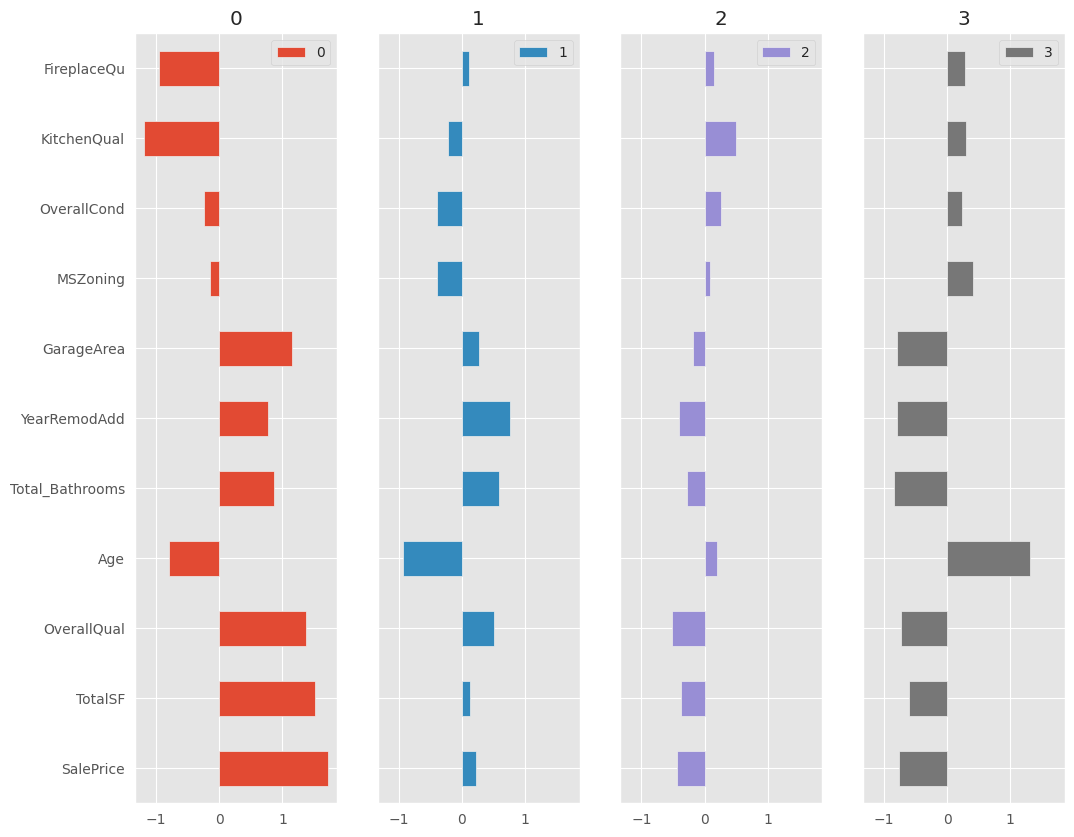

In [130]:
cluster_mean[1:].plot(figsize=(12, 10), kind="barh", subplots=True, layout=(1, 4), sharey=True)

K-means の結果の考察
- Cluster-0: 昔の古い住宅だが、Kitchen以外は全体的に Quality が高い上に広く、高価格な住宅群
- Cluster-1: 昔の古い家だが最近 Reform しており全体的な Quality は平均よりやや高い住宅群
- Cluster-2: 平均的な住宅群
- Cluster-3: 最近建てられた家だが狭く全体的な Quality も低い低価格な住宅群

### 主成分分析を行なう
変数が多いと Cluster分析の解釈が難しい為 **次元削除（次元圧縮）** を行なう。

In [131]:
from sklearn.decomposition import PCA

最終的に２次元に可視化することを考え、主成分の数を２としておく

In [132]:
pca = PCA(n_components=2)  # 主成分の数を指定
house_pca = pca.fit(train_scaled).transform(train_scaled)

In [133]:
house_pca

array([[ 2.68997501, -0.86006298],
       [ 0.54420742, -1.07344506],
       [ 3.30052853, -0.66387049],
       ...,
       [ 1.79762842,  3.76988429],
       [-3.04807309, -1.32722948],
       [-0.68777798, -1.4702792 ]])

In [134]:
# 出力結果を DataFrame 形式に変換してもとの DataFrame と結合する
df_house_pca = pd.DataFrame(house_pca)
df_house_pca.columns = ["pca1", "pca2"]

In [135]:
df_train_scaled = pd.concat([df_train_scaled, df_house_pca], axis=1)
df_train_scaled

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,SalePrice,hasHighFacility,Age,TotalSF,Total_Bathrooms,hasPorch,SalePrice_log,km_cluster,pca1,pca2
0,0.069617,-0.045768,-0.288764,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,-1.205075,...,0.387825,-0.325762,-1.046470,0.038930,1.736093,0.4596,0.586795,1,2.689975,-0.860063
1,-0.877169,-0.045768,-0.075476,0.058926,0.744525,0.310054,-0.026316,-0.634124,-0.222579,1.958565,...,0.031995,-0.325762,-0.188288,-0.017716,0.640132,0.4596,0.233882,2,0.544207,-1.073445
2,0.069617,-0.045768,0.230544,0.058926,-1.387256,0.310054,-0.026316,0.601627,-0.222579,-1.205075,...,0.585509,-0.325762,-0.980456,0.227753,1.736093,0.4596,0.763584,1,3.300529,-0.663870
3,0.306313,-0.045768,-0.084750,0.058926,-1.387256,0.310054,-0.026316,-1.869875,-0.222579,-1.038568,...,-0.514930,-0.325762,1.792130,-0.086502,-0.455829,0.4596,-0.426767,3,-1.499711,2.179143
4,0.069617,-0.045768,0.788800,0.058926,-1.387256,0.310054,-0.026316,-0.634124,-0.222579,0.459998,...,0.934750,-0.325762,-0.947449,1.086897,1.736093,0.4596,1.048721,0,5.675500,1.025528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,0.069617,-0.045768,-0.387617,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,-0.705553,...,-0.053668,-0.325762,-0.947449,0.084787,0.640132,0.4596,0.141076,1,1.386638,0.084230
1441,-0.877169,-0.045768,0.587568,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,0.293491,...,0.407594,-0.325762,-0.155281,1.453753,0.640132,0.4596,0.605037,2,1.706249,0.427903
1442,0.306313,-0.045768,-0.178967,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,-1.038568,...,1.152202,2.854821,1.065977,1.287858,-0.455829,0.4596,1.211364,1,1.797628,3.769884
1443,-0.877169,-0.045768,-0.053777,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,-0.039524,...,-0.486925,-0.325762,0.768914,-0.514051,-0.455829,0.4596,-0.388431,2,-3.048073,-1.327229


In [136]:
# 主成分分析の結果を可視化
my_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

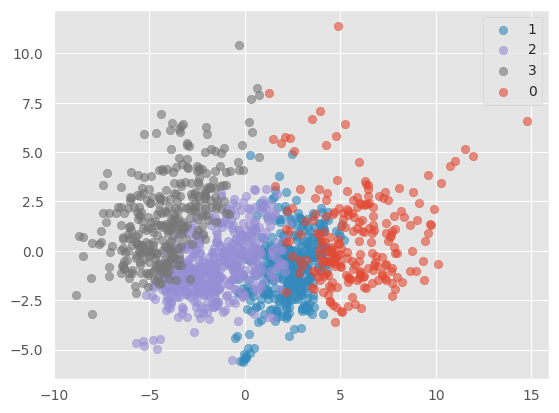

In [137]:
for cl in df_train_scaled["km_cluster"].unique():
    plt.scatter(df_train_scaled.loc[df_train_scaled["km_cluster"] == cl, "pca1"],
                df_train_scaled.loc[df_train_scaled["km_cluster"] == cl, "pca2"]
                , label=cl
                , c=my_colors[cl]
                , alpha=0.6)

plt.legend()
plt.show()

In [138]:
# 第１主成分、第２主成分に対いして、どのような変数が寄与しているか確認する
df_pca_comp = pd.DataFrame(pca.components_, columns=df_train_scaled.drop(["km_cluster", "pca1", "pca2"], axis=1).columns).T
df_pca_comp.columns = ["pca1", "pca2"]

In [139]:
df_pca_comp

,pca1,pca2
MSSubClass,-0.004495,-0.006499
MSZoning,-0.067847,0.059128
LotArea,0.082411,0.144455
Street,0.010466,0.015534
LotShape,-0.078720,0.003228
...,...,...
Age,-0.199940,0.237253
TotalSF,0.217847,0.185554
Total_Bathrooms,0.190397,0.042324
hasPorch,0.092300,0.037752
